In [1]:
pwd

'/n/holystore01/LABS/finkbeiner_lab/Everyone/fink2/jyin/yay'

In [1]:
from __future__ import print_function
%matplotlib inline 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import os
import sys
import glob
import h5py
import numpy as np
import math
import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset , DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from tqdm import tqdm
#import tensorboard
#import tensorboardX
#from torch.utils.tensorboard import SummaryWriter
#from log import Logger
#from data import trainlabelDataset_reduced, testlabelDataset_reduced
#from util import r2, mse, rmse, mae, pp_mse, pp_rmse, pp_mae
#from model import  autoencoder_999, autoencoder_333, autoencoder_333_2, autoencoder_1014,autoencoder_1015
from sklearn.decomposition import PCA
import random 
from scipy import stats
import seaborn as sns
#sns.set(color_codes=True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [32]:
def p(a,b,c,d,j):
    fig, ax = plt.subplots(2,2, figsize=(15,10))

    # Plot original image with noise
    im = ax[0][0].imshow(a[j])
    fig.colorbar(im, ax=ax[0][0])
    ax[0][0].set_title('aaaaa')

    # Plot original image with no noise
    im = ax[0][1].imshow(b[j])
    fig.colorbar(im, ax=ax[0][1])
    ax[0][1].set_title('bbbb')

    # Plot reconstructed image
    im = ax[1][0].imshow(c[j])
    fig.colorbar(im, ax=ax[1][0])
    ax[1][0].set_title('cccc')

    # Plot difference between original and reconstructed image

    im = ax[1][1].imshow(d[j])
    fig.colorbar(im, ax=ax[1][1])
    ax[1][1].set_title('dddd')

    fig.tight_layout();


In [4]:
expname='cae_9098'

In [5]:


reg=1e-3
################    

    
class testlabelDataset_cae(Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self):
        
     #   f= h5py.File('test_yay_preproc.h5','r')
        f= h5py.File('test_lala1202_preproc.h5','r')
        image = f['img'][:]    
        cat = f['cat'][:]
        label = f['label'][:]
        snr = f['snr'][:]
        sigma = f['sigma'][:]
        psf_r=f['psf_r'][:]
        image_nonoise = f['img_nonoise'][:]    
        image_withnoise = f['img_withnoise'][:]    
        f.close()
        
        
        
        image.astype('float32')
        cat.astype('float32')
        label.astype('float32')
        snr.astype('float32')
        sigma.astype('float32')
        psf_r.astype('float32')
        image_nonoise.astype('float32')
        image_withnoise.astype('float32')
        
        self.len = image.shape[0]
        self.image= torch.from_numpy(image[:])
        self.cat= torch.from_numpy(cat[:])
        self.label=torch.from_numpy(label[:])
        self.snr=torch.from_numpy(snr[:])
        self.sigma=torch.from_numpy(sigma[:])
        self.psf_r=torch.from_numpy(psf_r[:])
        self.imagenonoise= torch.from_numpy(image_nonoise[:])
        self.imagewithnoise= torch.from_numpy(image_withnoise[:])        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.imagenonoise[index],self.cat[index], self.label[index], self.snr[index] , self.sigma[index],self.psf_r[index], self.imagewithnoise[index]
        
    
      
 
    

class autoencoder_1110_con(nn.Module):   # 
    def __init__(self):            #  4x 64 x 64 
        
        super(autoencoder_1110_con, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 128, 3, stride=1),  # 128 * 62 * 62 
            nn.BatchNorm2d(128), 
            nn.ReLU(True),
            
            nn.Conv2d(128, 256, 3, stride=1),  #   256 * 60 * 60 
            nn.BatchNorm2d(256), 
            nn.ReLU(True),

            nn.Conv2d(256, 512, 3, stride=2),  #  512 * 29 * 29 
            nn.BatchNorm2d(512), 
            nn.ReLU(True),
            
            nn.Conv2d(512, 1024, 3, stride=1),  #  1024 * 27 * 27 
            nn.BatchNorm2d(1024), 
            nn.ReLU(True),
            
            
            nn.Conv2d(1024, 512, 3, stride=1),  #  512 * 25*25
            nn.BatchNorm2d(512),     
            nn.ReLU(True),
            
            nn.Conv2d(512, 256, 3, stride=1, padding=1 ),  #  256 
            nn.BatchNorm2d(256), 
            nn.ReLU(True),
            
            
            nn.Conv2d(256, 128, 3, stride=2, padding=2),  # b, 128 
            nn.BatchNorm2d(128), 
            nn.ReLU(True),
            
            
            
            nn.Conv2d(128, 64, 3, stride=1, padding=1),  # b, 64 x 16 x16 
            nn.BatchNorm2d(64),       
            nn.ReLU(True),
            
            
            nn.Conv2d(64, 1, 3, stride=1), ) # b,    1 * 12 *12          )
       
    
        self.lin_1= nn.Linear(12*12+1, 12*12+1)
        self.lin_2= nn.Linear(12*12+1, 14*14)


        self.decoder = nn.Sequential(

            
            
            nn.ConvTranspose2d(1, 128, 3, stride=2,padding=1),  # b, 64,  29,29 
            nn.BatchNorm2d(128), 
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 256, 3, stride=2),  # b, 64, 59, 59 
            nn.BatchNorm2d(256), 
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 512, 3, stride=1),  # b, 64, 59, 59 
            nn.BatchNorm2d(512), 
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, stride=1),  # b, 64, 59, 59 
            nn.BatchNorm2d(256), 
            nn.ReLU(True),            
            
            nn.ConvTranspose2d(256, 128, 3, stride=1),  # 128, 61, 61
            nn.BatchNorm2d(128), 
            nn.ReLU(True),              ##### add in attention  
            
            nn.ConvTranspose2d(128, 1, 3, stride=1),  # b, 1,64,64          
        )
        
        
        
        
    def forward(self, x,img_orig,sigma):
        z_1 = self.encoder(x)
        
        # add the average pixel value as the last neuron in the fully connected layer 
        #img 64x64, normalize by sigma

        
        avg=  img_orig.sum(dim=3).sum(dim=2).sum(dim=1)/64/64/sigma
        
        trained_=z_1.view(z_1.size(0),12*12)
        
        
        avg_flux= avg.view(x.size(0),1)
    
        z_2= torch.cat((trained_,avg_flux),dim=1)
        
        
        
        
        
        
        z = self.lin_1(z_2)
        
        z_3 = self.lin_2(z)
        
        x=self.decoder(z_3.view(z.size(0),1,14,14))
        
        return  x,z   
    
    
    


    



In [6]:
    
dataset= testlabelDataset_cae()
dataloader= DataLoader(dataset=dataset, batch_size=200,shuffle=True,drop_last=True,)

model = autoencoder_1110_con().cuda()   ############################################################## AE model 
#model.load_state_dict(torch.load('gal_img1107/cae_9031_4_train_best.pth'))    

criterion_none = nn.L1Loss(reduction='none')
criterion_mean = nn.L1Loss(reduction='mean')
criterion_none_mse = nn.MSELoss(reduction='none')
criterion_mean_mse = nn.MSELoss(reduction='mean')


In [1]:
pwd

'/n/holystore01/LABS/finkbeiner_lab/Everyone/fink2/jyin/yay'

In [7]:
num=600#200  # 600 is goood 

model.load_state_dict(torch.load('gal_img1107/'+expname+'_train_{}.pth'.format(num)))
 
#model.load_state_dict(torch.load('gal_img1107/cae_9098_train_600.pth'))
 
#model.load_state_dict(torch.load('gal_img1107/'+expname+'_train_best.pth'))    
model.eval()

num_examples = 0.0
test_num_examples=0.0
test_total_loss = 0.0    
test_total_mse=0.0
test_total_recon=0.0
test_total_latent=0.0
batch_size=500
for data in dataloader:
    test_img_orig,test_img,test_label,snr,sigma,psf_r,test_img_withnoise= [x.type(torch.float32).cuda() for x in data]
    test_img_orig=test_img_orig.view(test_img.size(0),1,64,64)
    test_img = test_img.view(test_img.size(0), 6,64,64)
    test_output,test_z = model(test_img,test_img_orig,sigma)
    test_z=test_z.view(test_z.size(0),12*12+1)
    
    
    
        

res_in =  test_img_orig.data.cpu().numpy()   
res_out=test_output.data.cpu().numpy()
label_in=test_label.data.cpu().numpy()
label_out=test_z[:,:5].data.cpu().numpy()
snr=snr.data.cpu().numpy()
sigma=sigma.data.cpu().numpy()
psf_r=psf_r.data.cpu().numpy()
test_img_withnoise=test_img_withnoise.data.cpu().numpy()

print("Correlation between predicted values and true values for 5 parameters are: ")
cov_sum=0
for i in range(5):
    cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))

    print(cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))
    cov_sum=cov_sum+cov[0,1]/np.sqrt(cov[0][0] * cov[1][1])
print("cov_mean,",cov_sum/5 )    




flux=label_in[:,0]*1e5 

Correlation between predicted values and true values for 5 parameters are: 
0.9879531511077955
0.7964152503330755
0.8647427618771838
0.9247729703803249
0.9216998797617102
cov_mean, 0.899116802692018


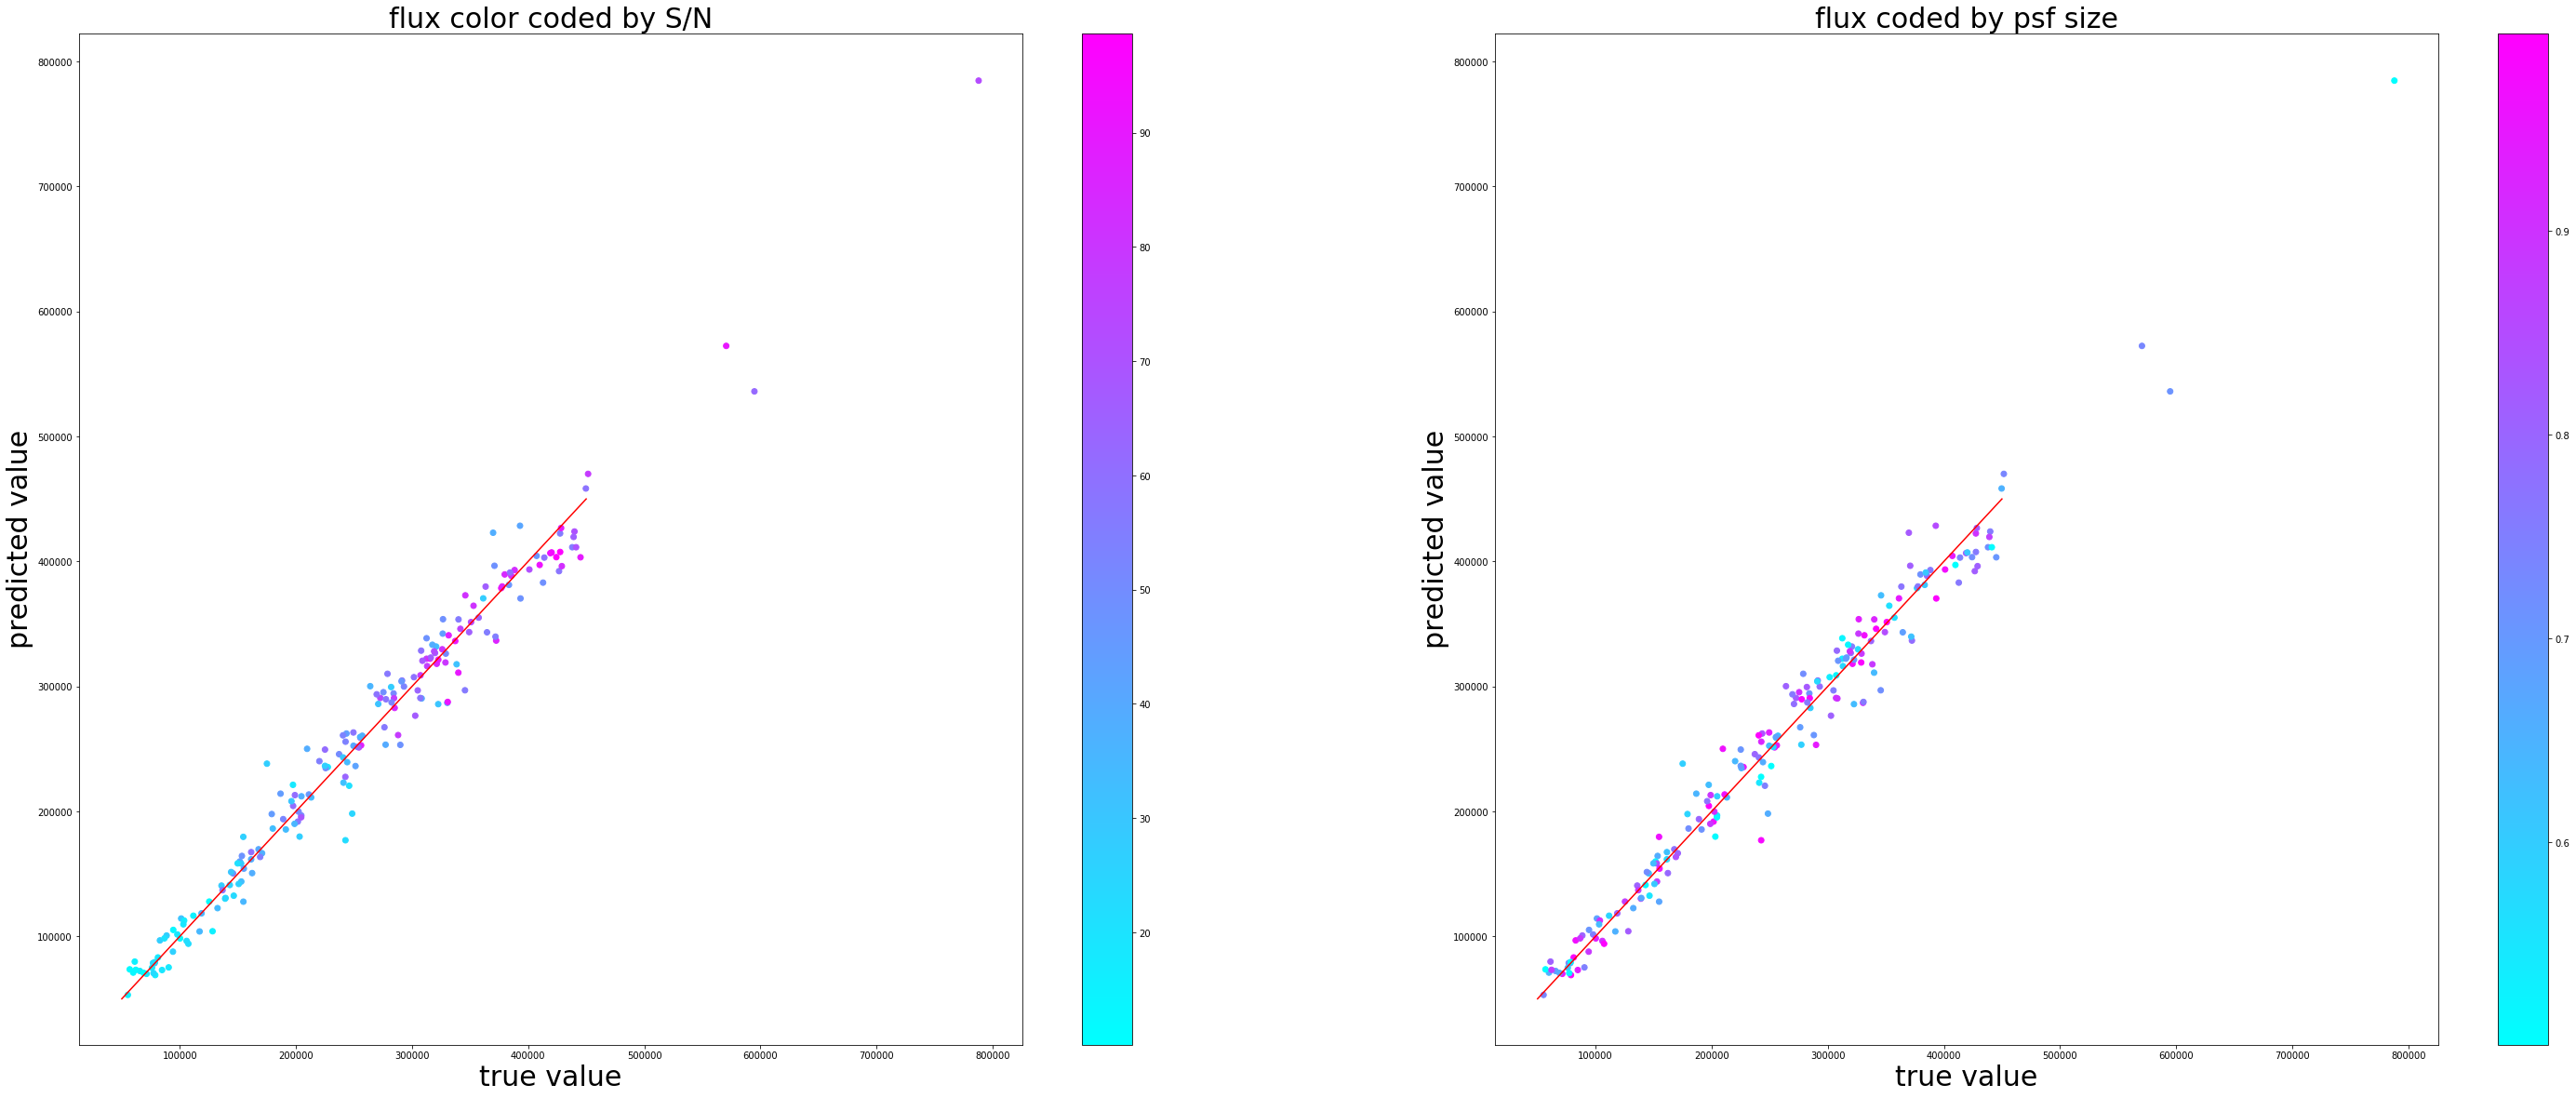

In [8]:
i=0

plt.figure(figsize=(50,20))




plt.subplot(1, 2, 1)
x=np.linspace(.5e5,4.5e5,100)
plt.plot(x,x,'red')
plt.scatter(label_in[:,i]*1e5,label_out[:,i]*1e5,c=snr,cmap='cool')
plt.xlabel("true value", fontsize=30)
plt.ylabel("predicted value", fontsize=30)
plt.title("flux color coded by S/N", fontsize=30)
plt.colorbar()


plt.subplot(1, 2, 2)
x=np.linspace(.5e5,4.5e5,100)
plt.plot(x,x,'red')
plt.scatter(label_in[:,i]*1e5,label_out[:,i]*1e5,c=psf_r,cmap='cool')
plt.xlabel("true value", fontsize=30)
plt.ylabel("predicted value", fontsize=30)
plt.title("flux coded by psf size", fontsize=30)
plt.colorbar()

mean= 612.72797
standard deviation= 18512.504


/n/home01/jyin/.conda/envs/pyyay/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


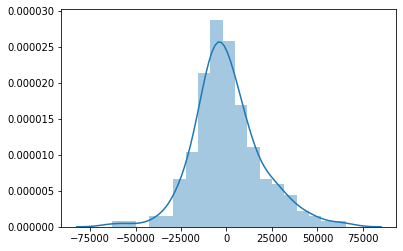

In [9]:
sns.distplot((label_in[:,i]*1e5-label_out[:,i]*1e5));
print('mean=',(label_in[:,i]*1e5-label_out[:,i]*1e5).mean())
print('standard deviation=',np.sqrt((label_in[:,i]*1e5-label_out[:,i]*1e5).var()))

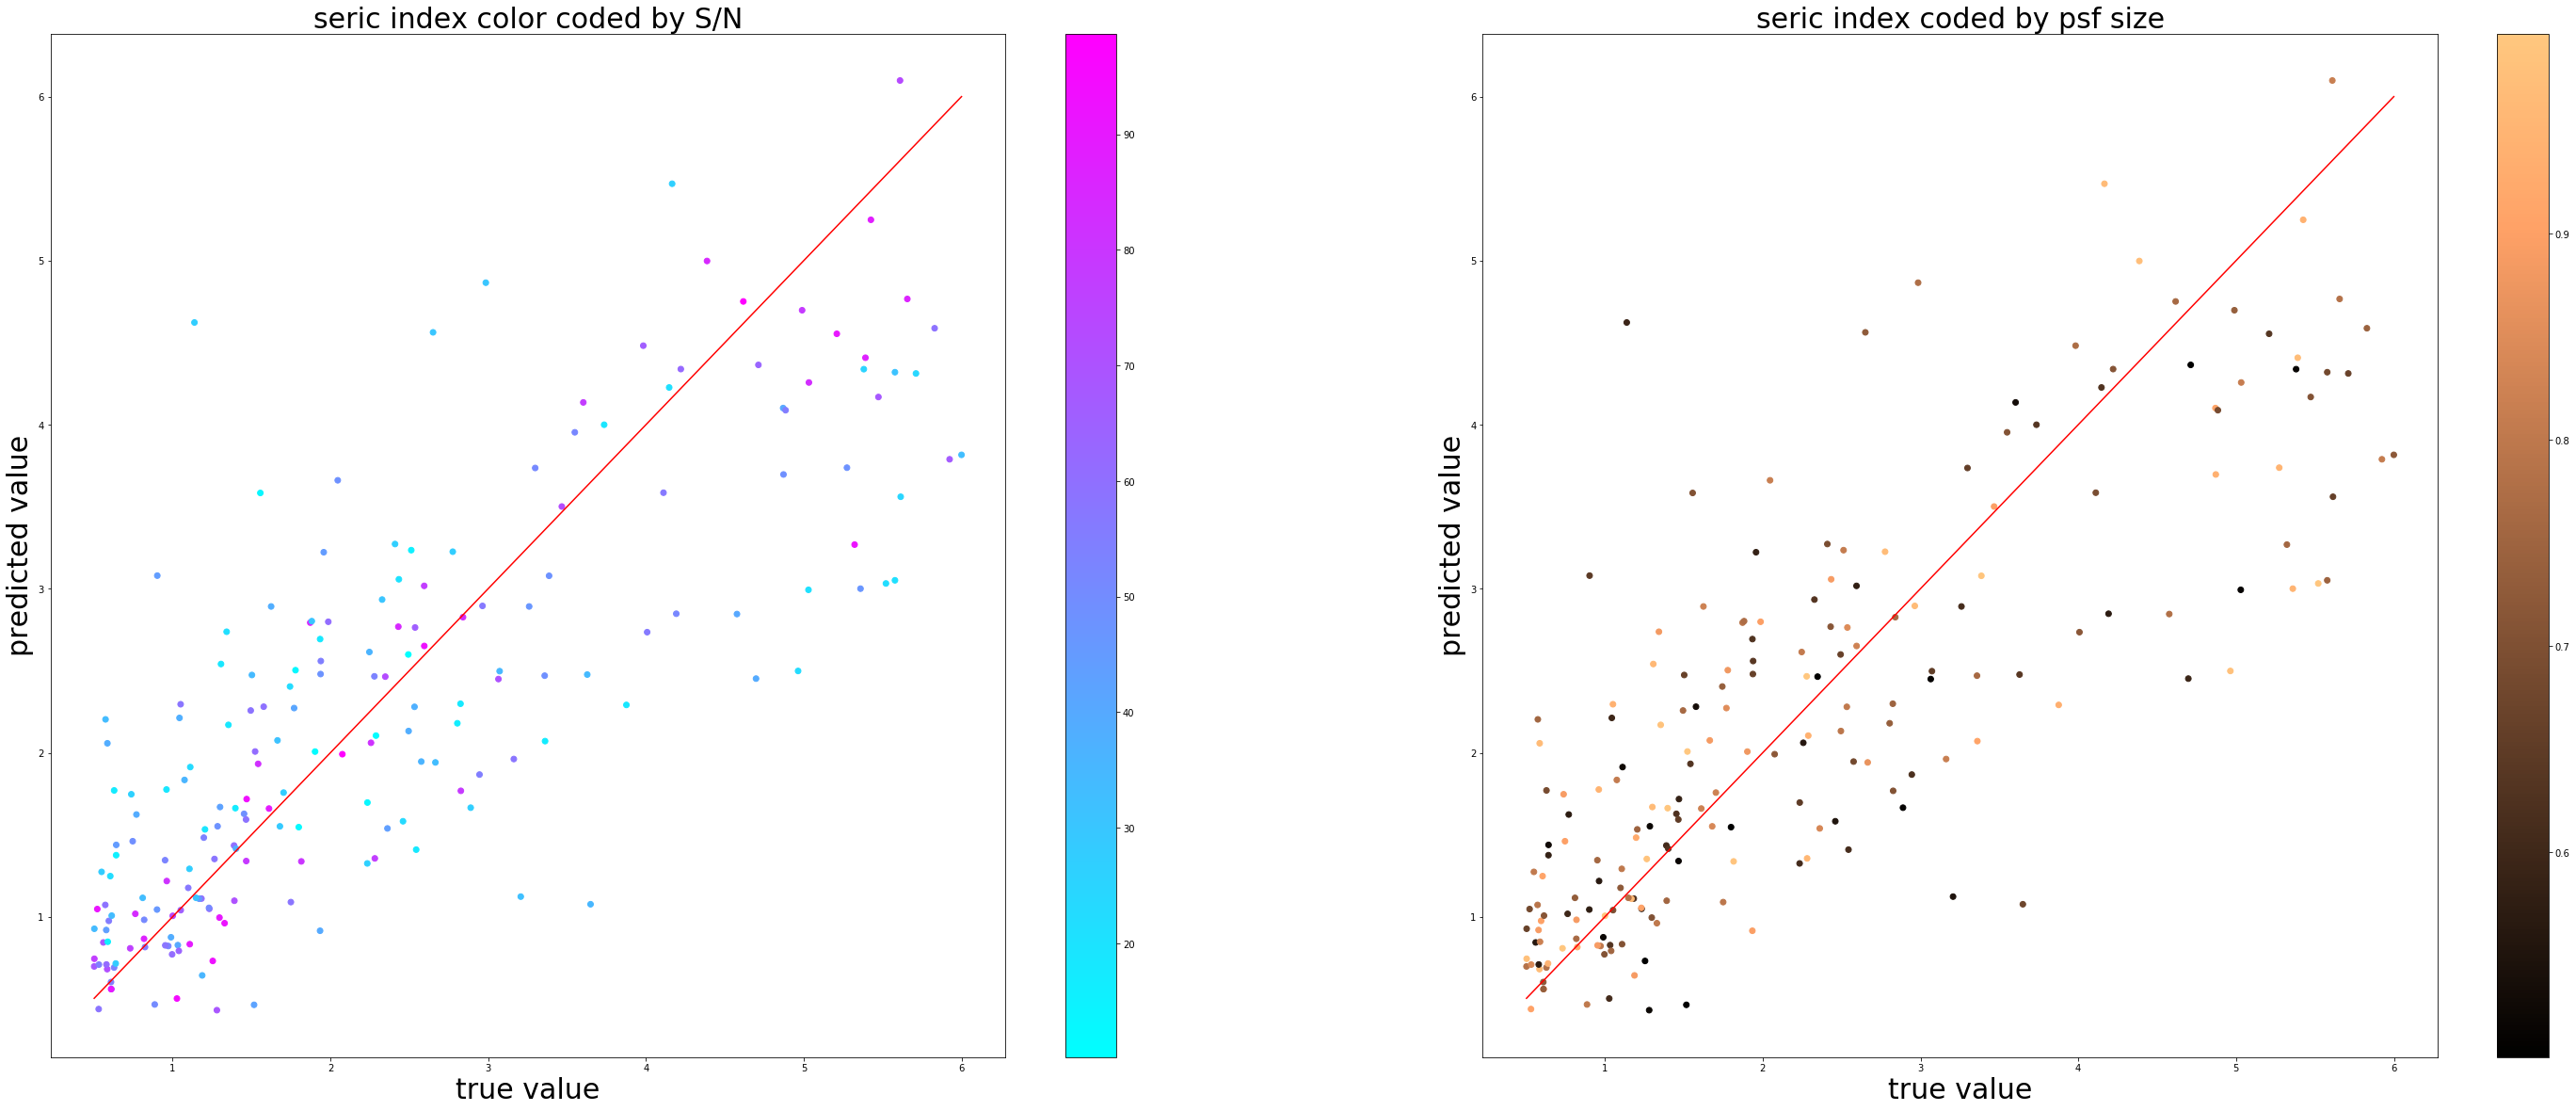

In [10]:
i=1

plt.figure(figsize=(50,20))
x=np.linspace(label_in[:,i].min(),label_in[:,i].max(),100)



plt.subplot(1, 2, 1)
plt.scatter(label_in[:,i],label_out[:,i],c=snr,cmap='cool')
plt.plot(x,x,'red')
plt.xlabel("true value", fontsize=30)
plt.ylabel("predicted value", fontsize=30)
plt.title("seric index color coded by S/N", fontsize=30)
plt.colorbar()


plt.subplot(1, 2, 2)
plt.scatter(label_in[:,i],label_out[:,i],c=psf_r,cmap='copper')
plt.plot(x,x,'red')
plt.xlabel("true value", fontsize=30)
plt.ylabel("predicted value", fontsize=30)
plt.title("seric index coded by psf size", fontsize=30)
plt.colorbar()

mean= 0.07233207
standard deviation= 0.9416816


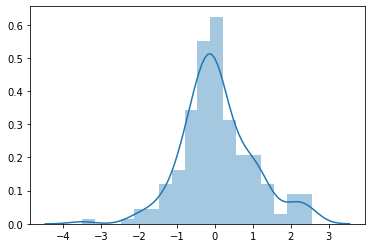

In [11]:
sns.distplot((label_in[:,i]-label_out[:,i]));
print('mean=',(label_in[:,i]-label_out[:,i]).mean())
print('standard deviation=',np.sqrt((label_in[:,i]-label_out[:,i]).var()))

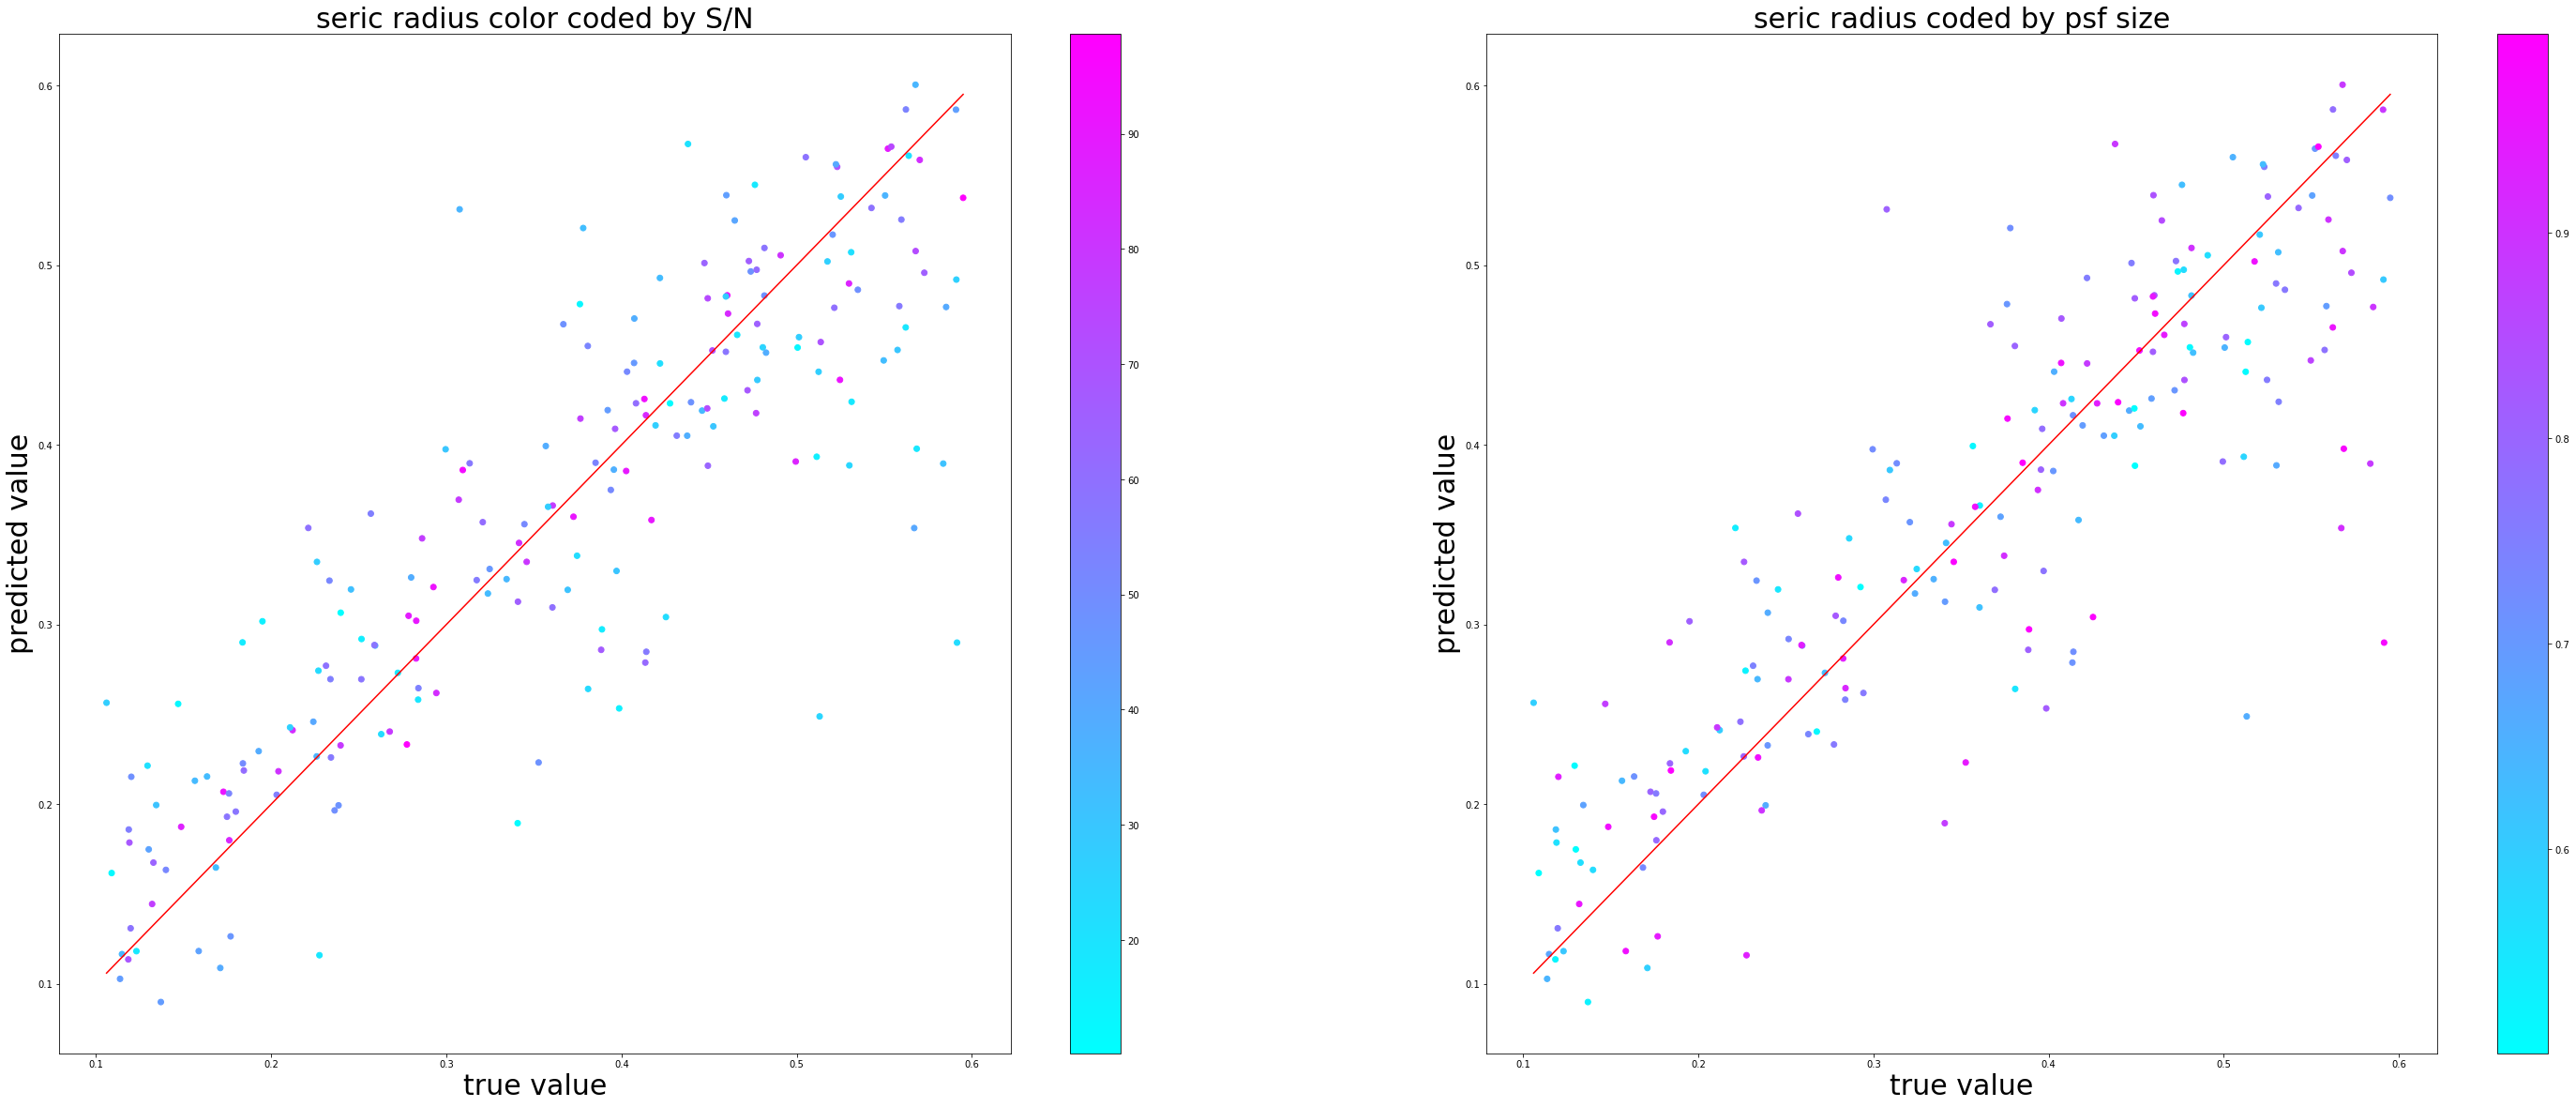

In [12]:
i=2

plt.figure(figsize=(50,20))
x=np.linspace(label_in[:,i].min(),label_in[:,i].max(),100)



plt.subplot(1, 2, 1)
plt.scatter(label_in[:,i],label_out[:,i],c=snr,cmap='cool')
plt.plot(x,x,'red')
plt.xlabel("true value", fontsize=30)
plt.ylabel("predicted value", fontsize=30)
plt.title("seric radius color coded by S/N", fontsize=30)
plt.colorbar()


plt.subplot(1, 2, 2)
plt.scatter(label_in[:,i],label_out[:,i],c=psf_r,cmap='cool')
plt.plot(x,x,'red')
plt.xlabel("true value", fontsize=30)
plt.ylabel("predicted value", fontsize=30)
plt.title("seric radius coded by psf size", fontsize=30)
plt.colorbar()

mean= 0.0041807243
standard deviation= 0.07106535


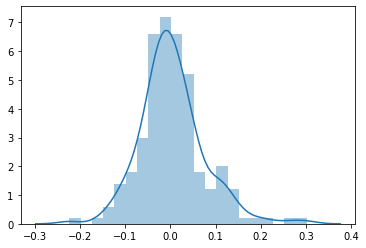

In [13]:
sns.distplot((label_in[:,i]-label_out[:,i]));
print('mean=',(label_in[:,i]-label_out[:,i]).mean())
print('standard deviation=',np.sqrt((label_in[:,i]-label_out[:,i]).var()))

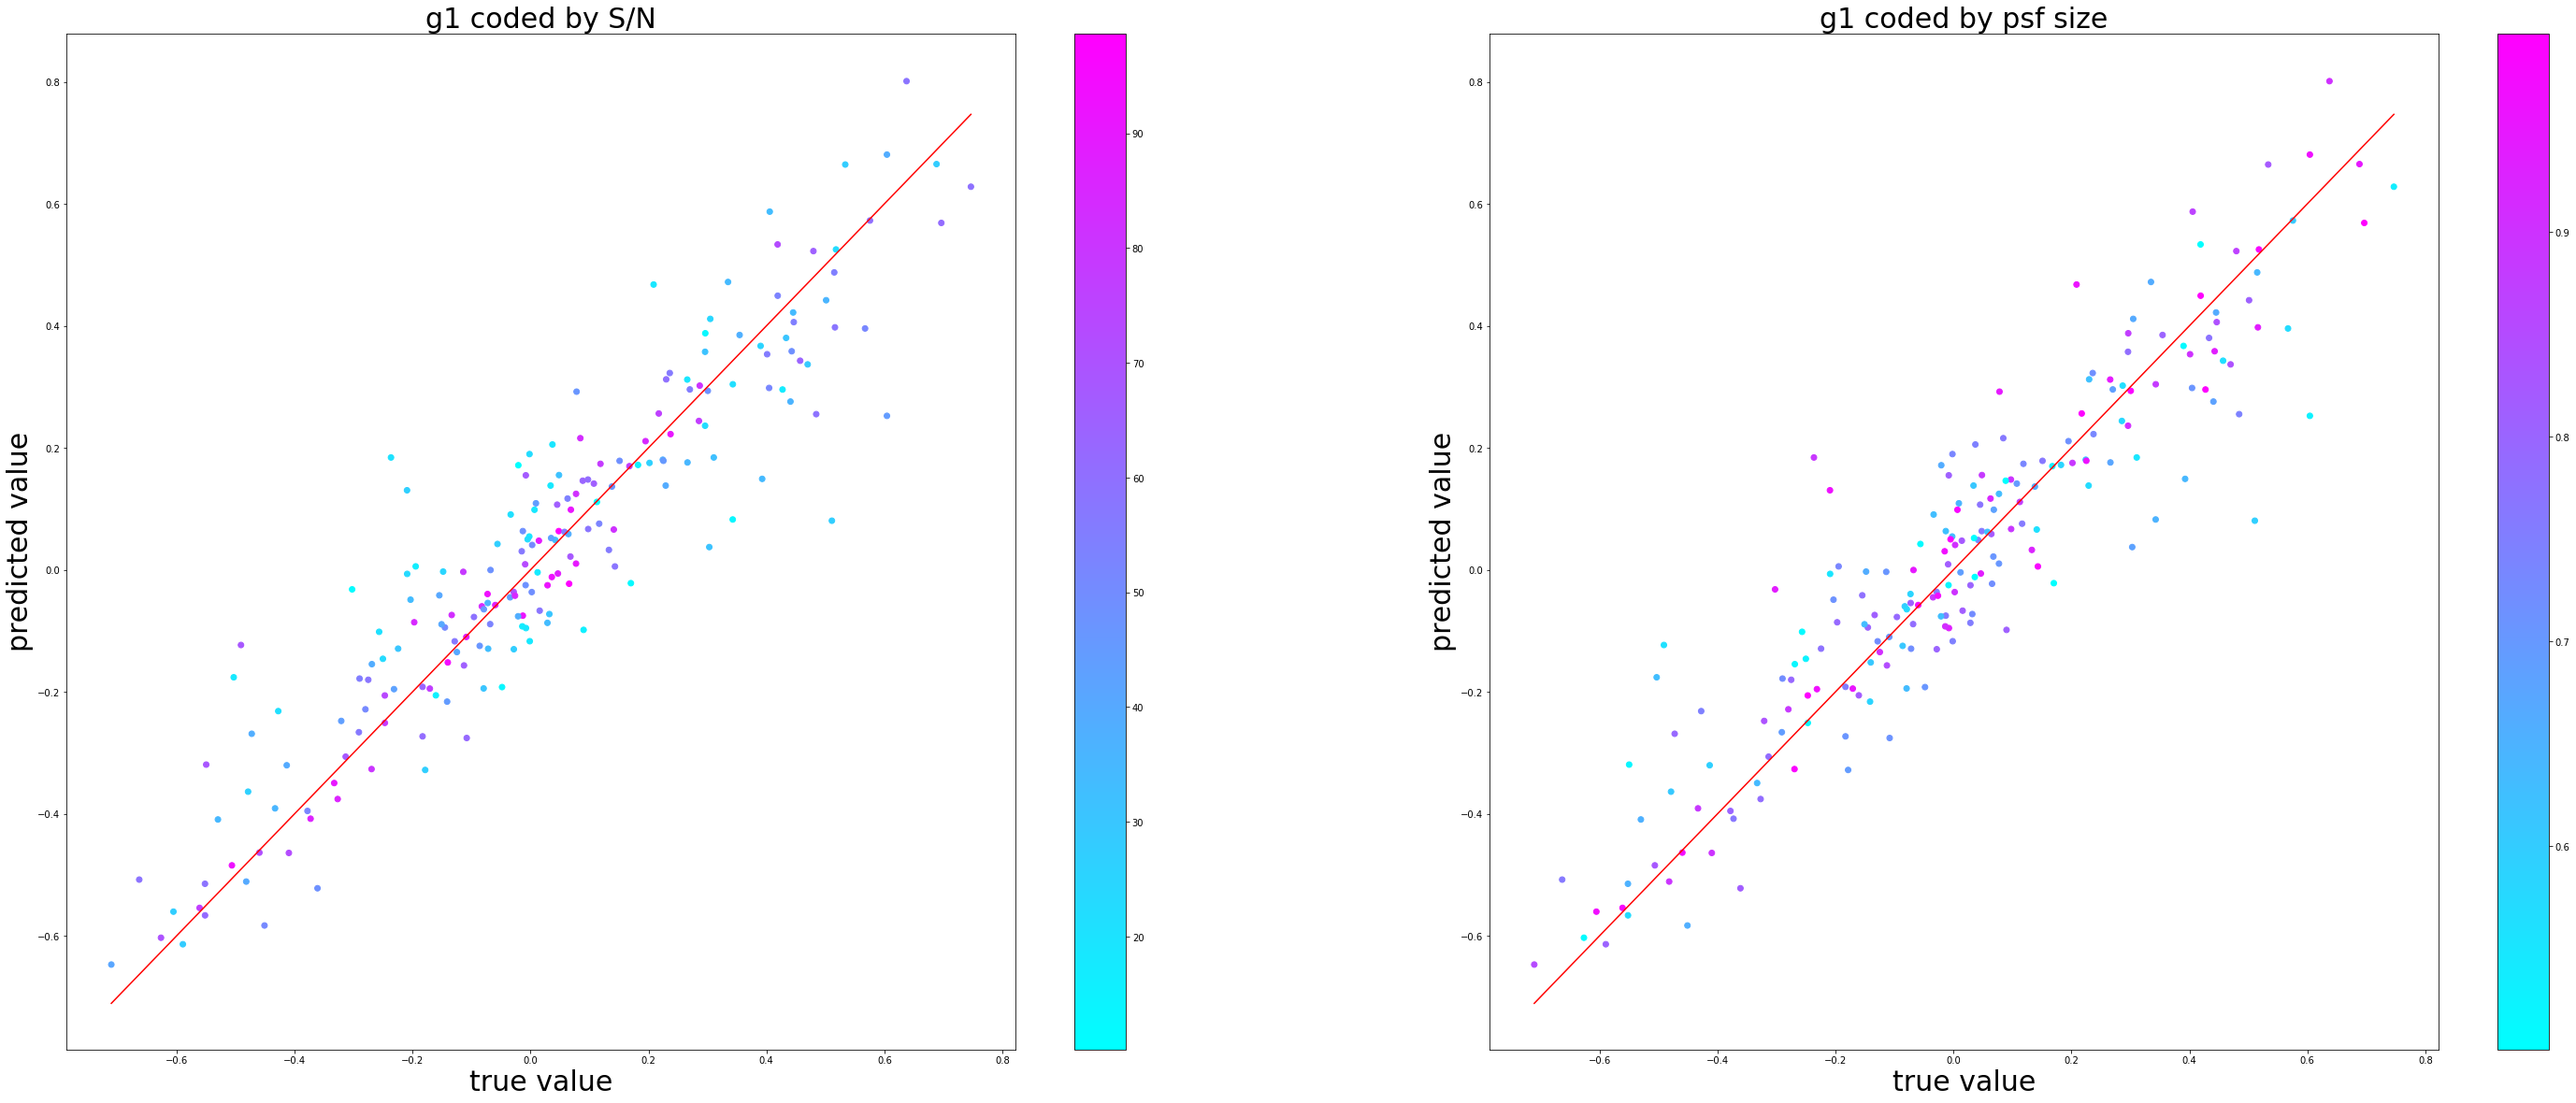

In [14]:
i=3

plt.figure(figsize=(50,20))

x=np.linspace(label_in[:,i].min(),label_in[:,i].max(),100)


plt.subplot(1, 2, 1)
plt.scatter(label_in[:,i],label_out[:,i],c=snr,cmap='cool')
plt.plot(x,x,'red')
plt.xlabel("true value", fontsize=30)
plt.ylabel("predicted value", fontsize=30)
plt.title("g1 coded by S/N", fontsize=30)
plt.colorbar()


plt.subplot(1, 2, 2)
plt.scatter(label_in[:,i],label_out[:,i],c=psf_r,cmap='cool')
plt.plot(x,x,'red')
plt.xlabel("true value", fontsize=30)
plt.ylabel("predicted value", fontsize=30)
plt.title("g1 coded by psf size", fontsize=30)
plt.colorbar()

mean= -0.010044637
standard deviation= 0.11714615


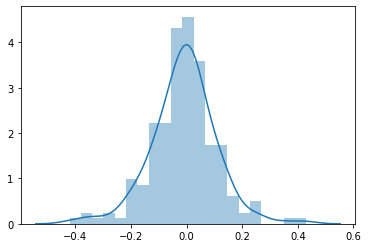

In [15]:
sns.distplot((label_in[:,i]-label_out[:,i]));
print('mean=',(label_in[:,i]-label_out[:,i]).mean())
print('standard deviation=',np.sqrt((label_in[:,i]-label_out[:,i]).var()))

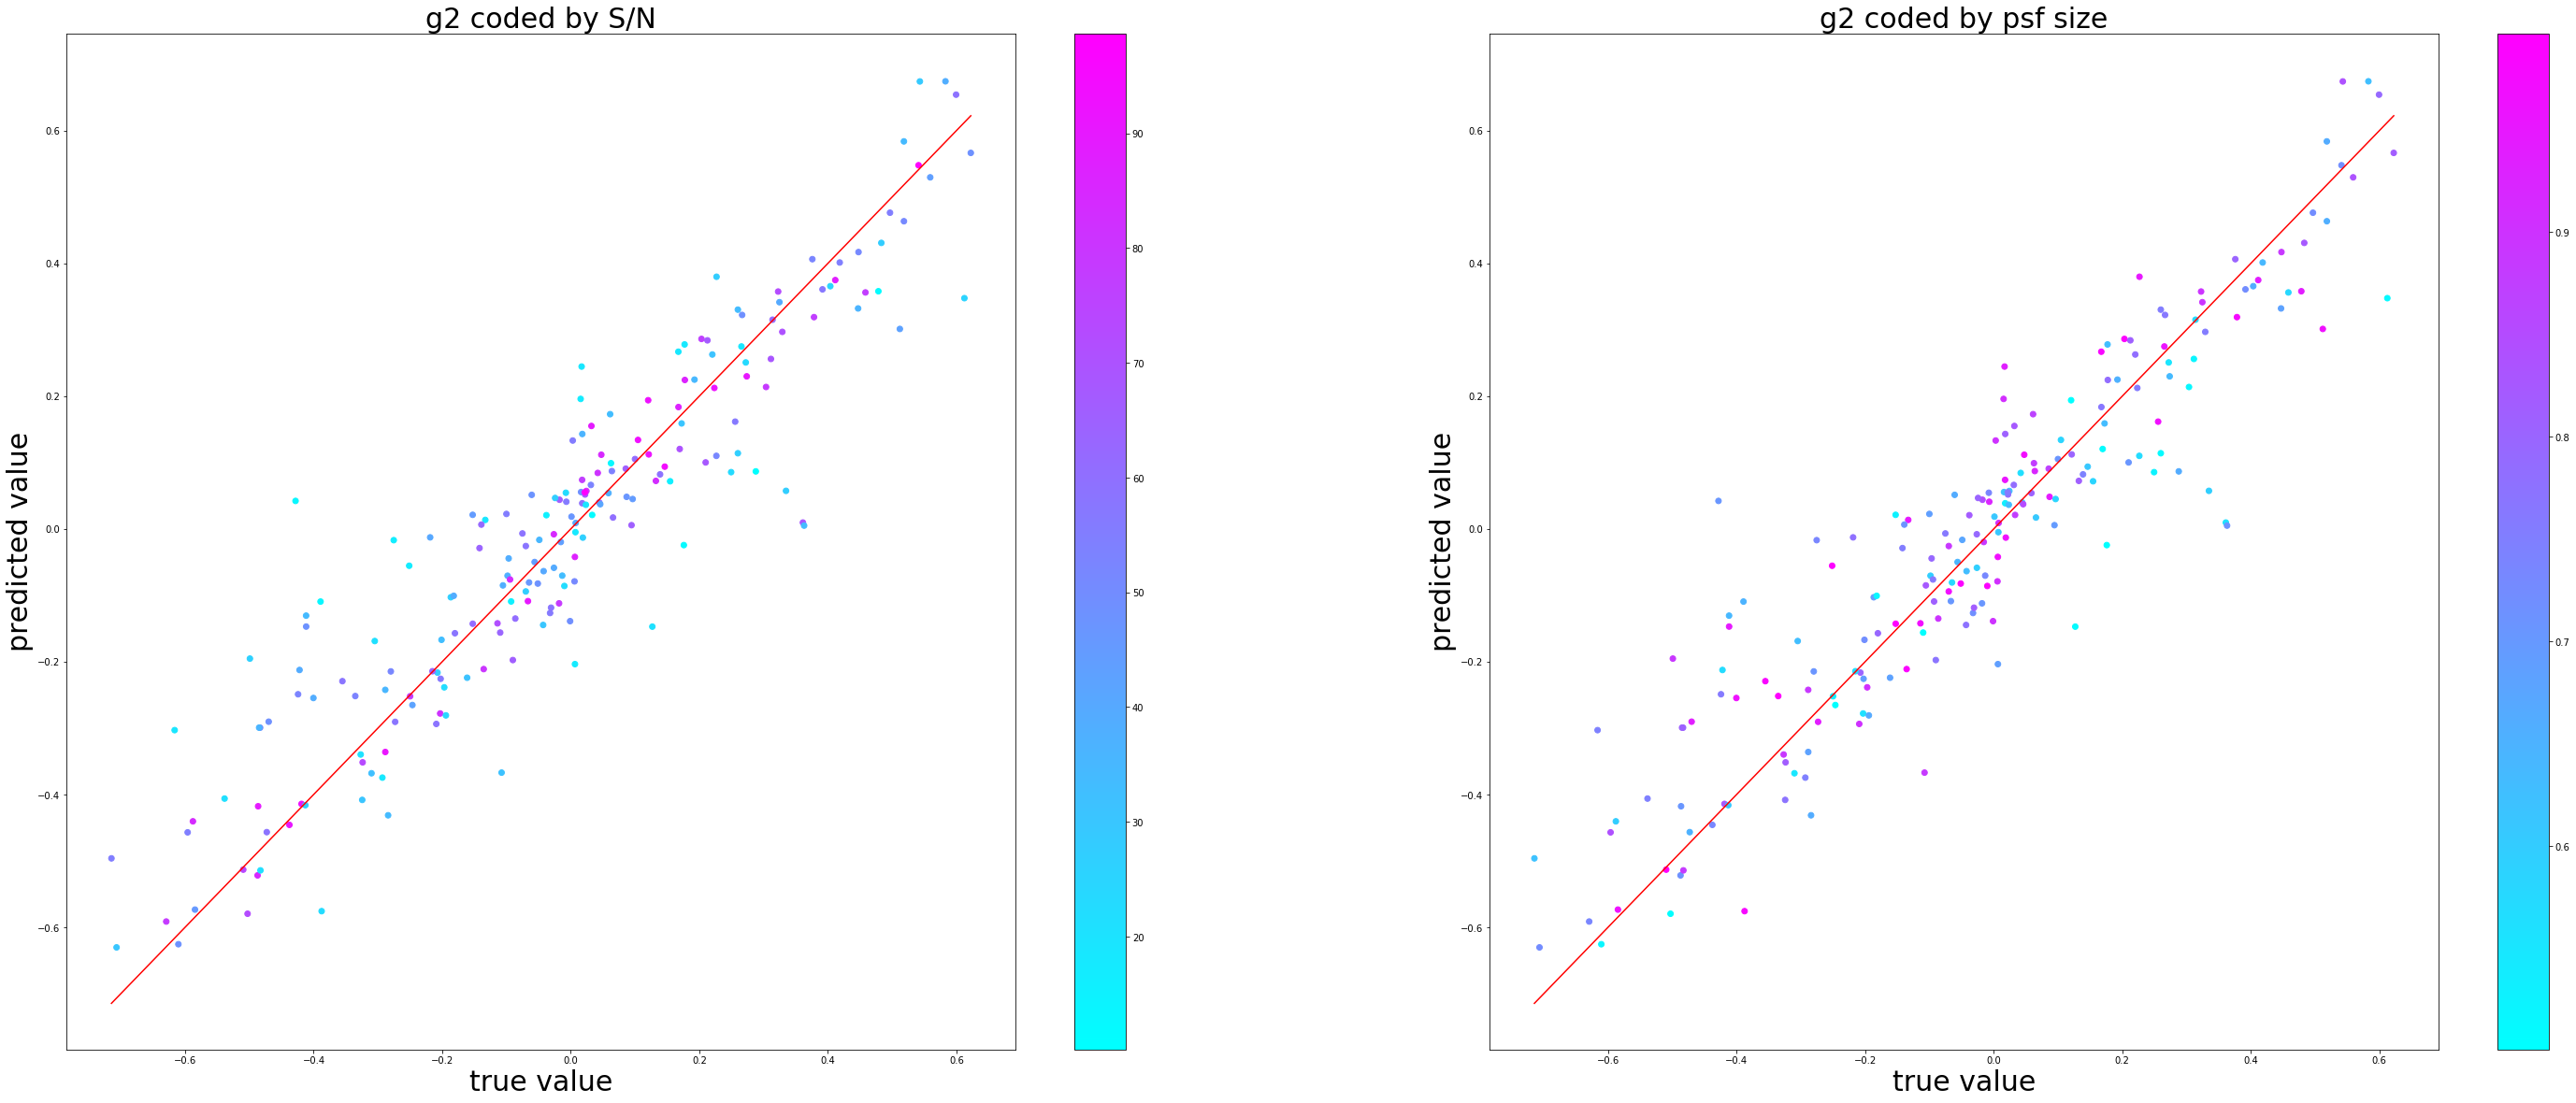

In [16]:
i=4

plt.figure(figsize=(50,20))

x=np.linspace(label_in[:,i].min(),label_in[:,i].max(),100)



plt.subplot(1, 2, 1)
plt.scatter(label_in[:,i],label_out[:,i],c=snr,cmap='cool')
plt.plot(x,x,'red')
plt.xlabel("true value", fontsize=30)
plt.ylabel("predicted value", fontsize=30)
plt.title("g2 coded by S/N", fontsize=30)
plt.colorbar()


plt.subplot(1, 2, 2)
plt.scatter(label_in[:,i],label_out[:,i],c=psf_r,cmap='cool')
plt.plot(x,x,'red')
plt.xlabel("true value", fontsize=30)
plt.ylabel("predicted value", fontsize=30)
plt.title("g2 coded by psf size", fontsize=30)
plt.colorbar()

mean= -0.009350421
standard deviation= 0.1157196


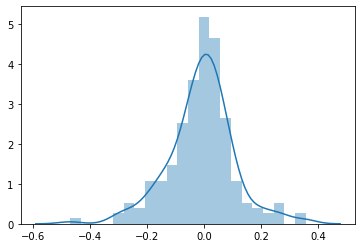

In [17]:
sns.distplot((label_in[:,i]-label_out[:,i]));
print('mean=',(label_in[:,i]-label_out[:,i]).mean())
print('standard deviation=',np.sqrt((label_in[:,i]-label_out[:,i]).var()))

In [18]:
index=np.argsort(snr)
withnoise=test_img_withnoise[index]
withoutnoise=res_in[index]
reconstructed=res_out[index]
snr_sorted=snr[index]

(array([23., 24., 24., 21., 24., 29., 15., 13., 15., 12.]),
 array([10.154267, 19.011448, 27.86863 , 36.72581 , 45.582993, 54.440174,
        63.297356, 72.15454 , 81.01172 , 89.868904, 98.72608 ],
       dtype=float32),
 <a list of 10 Patch objects>)

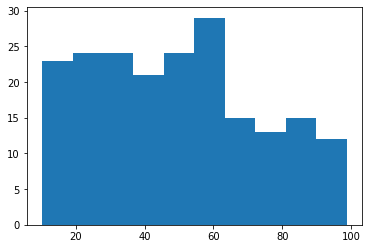

In [19]:
plt.hist(snr_sorted)

(array([23., 24., 24., 21., 24., 29., 15., 13., 15., 12.]),
 array([10.154267, 19.011448, 27.86863 , 36.72581 , 45.582993, 54.440174,
        63.297356, 72.15454 , 81.01172 , 89.868904, 98.72608 ],
       dtype=float32),
 <a list of 10 Patch objects>)

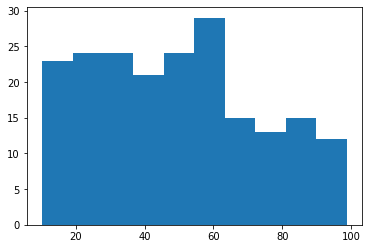

In [20]:
#snr_sorted
plt.hist(snr_sorted)

S/N= 10.154267
Sigma= 315.6861


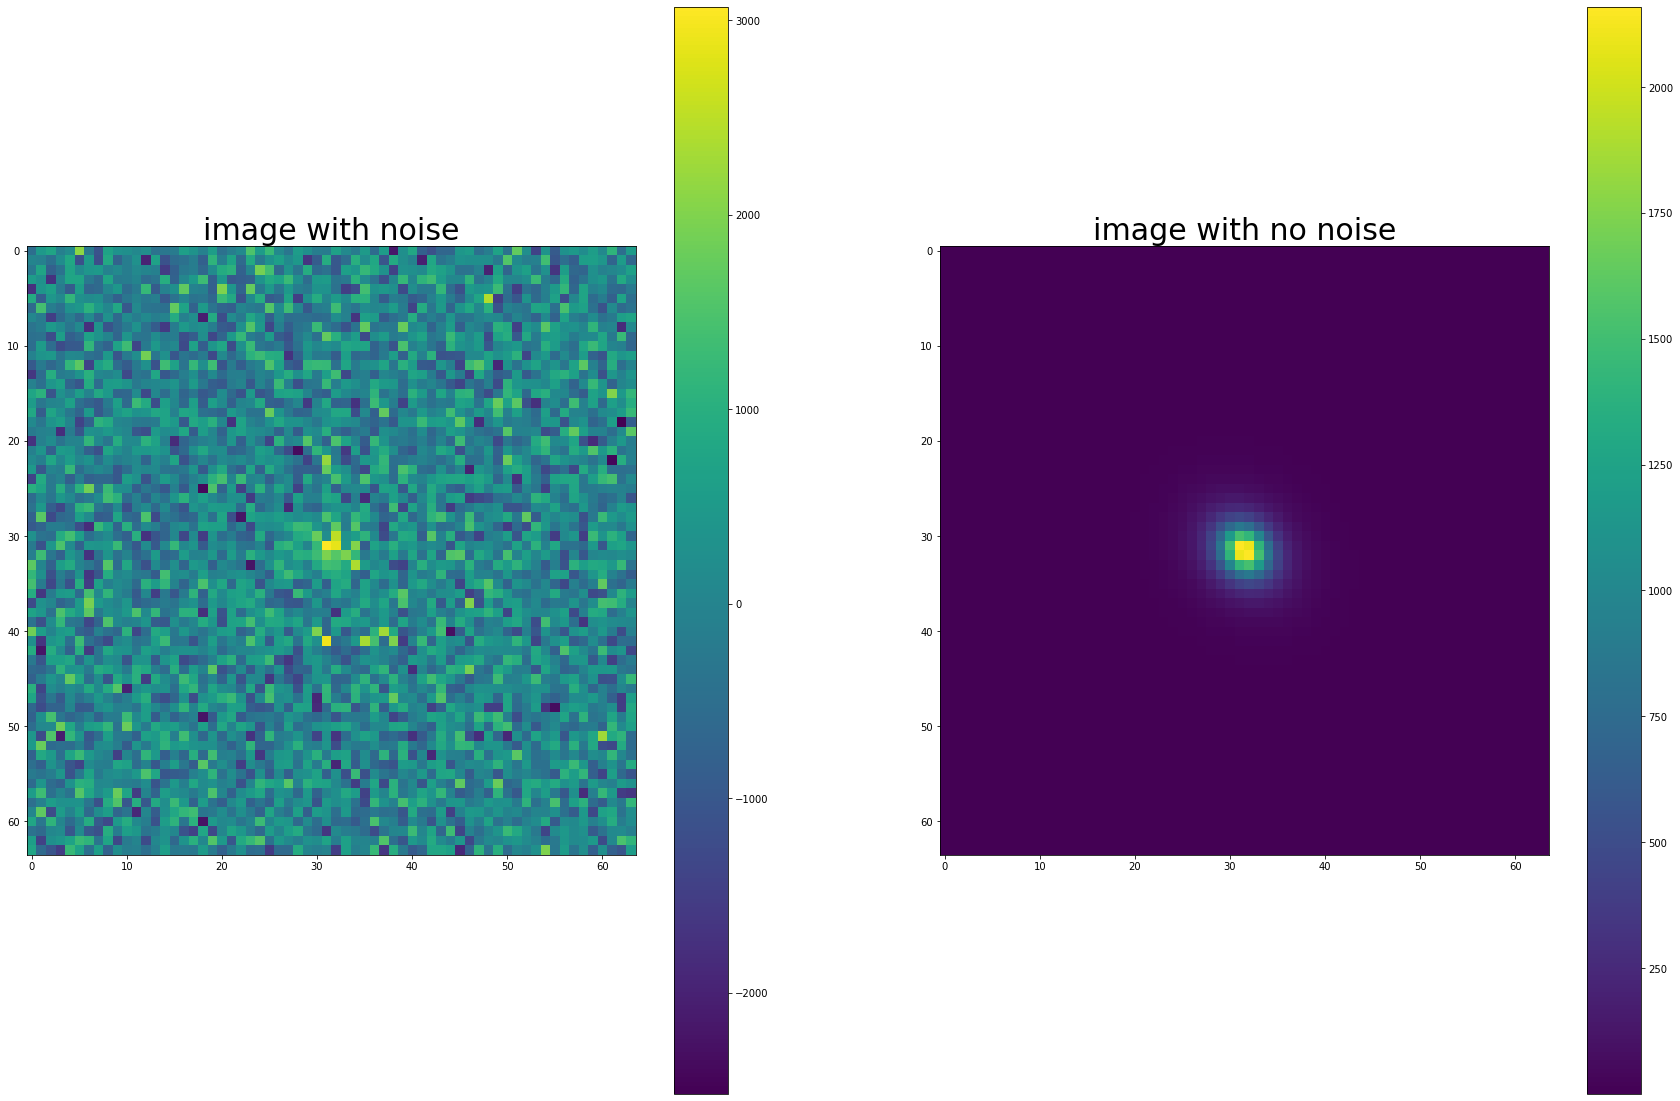

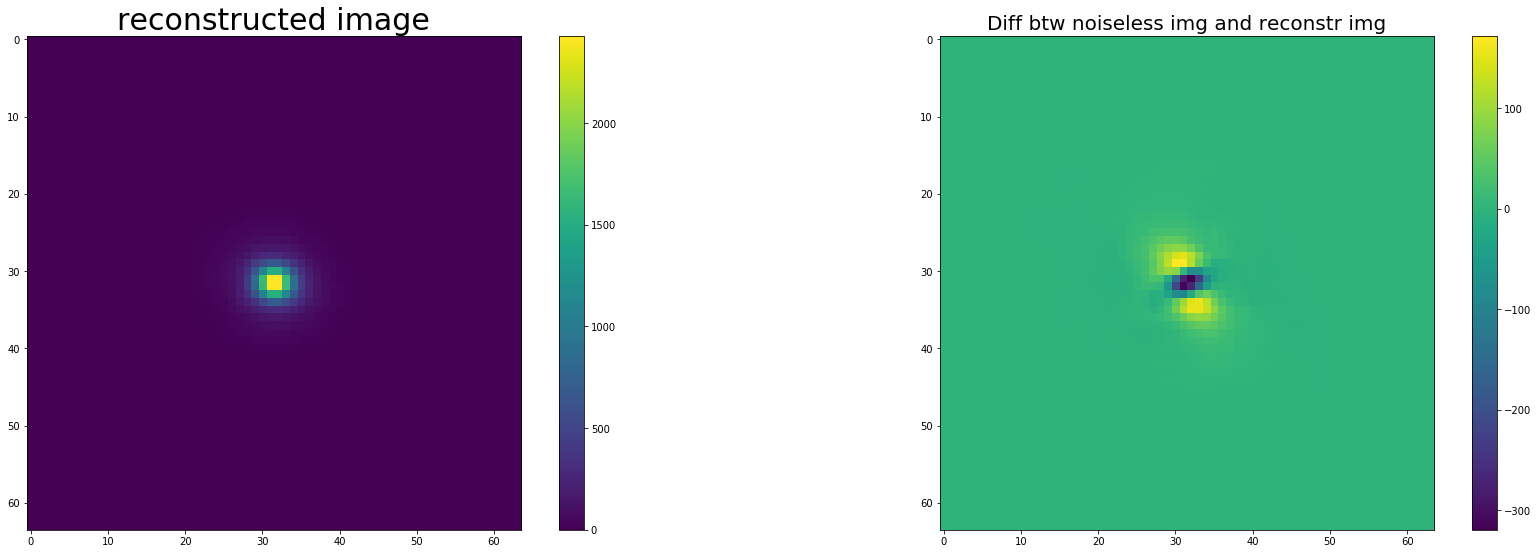

In [21]:
i=0
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no noise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

S/N= 22.450212
Sigma= 377.2272


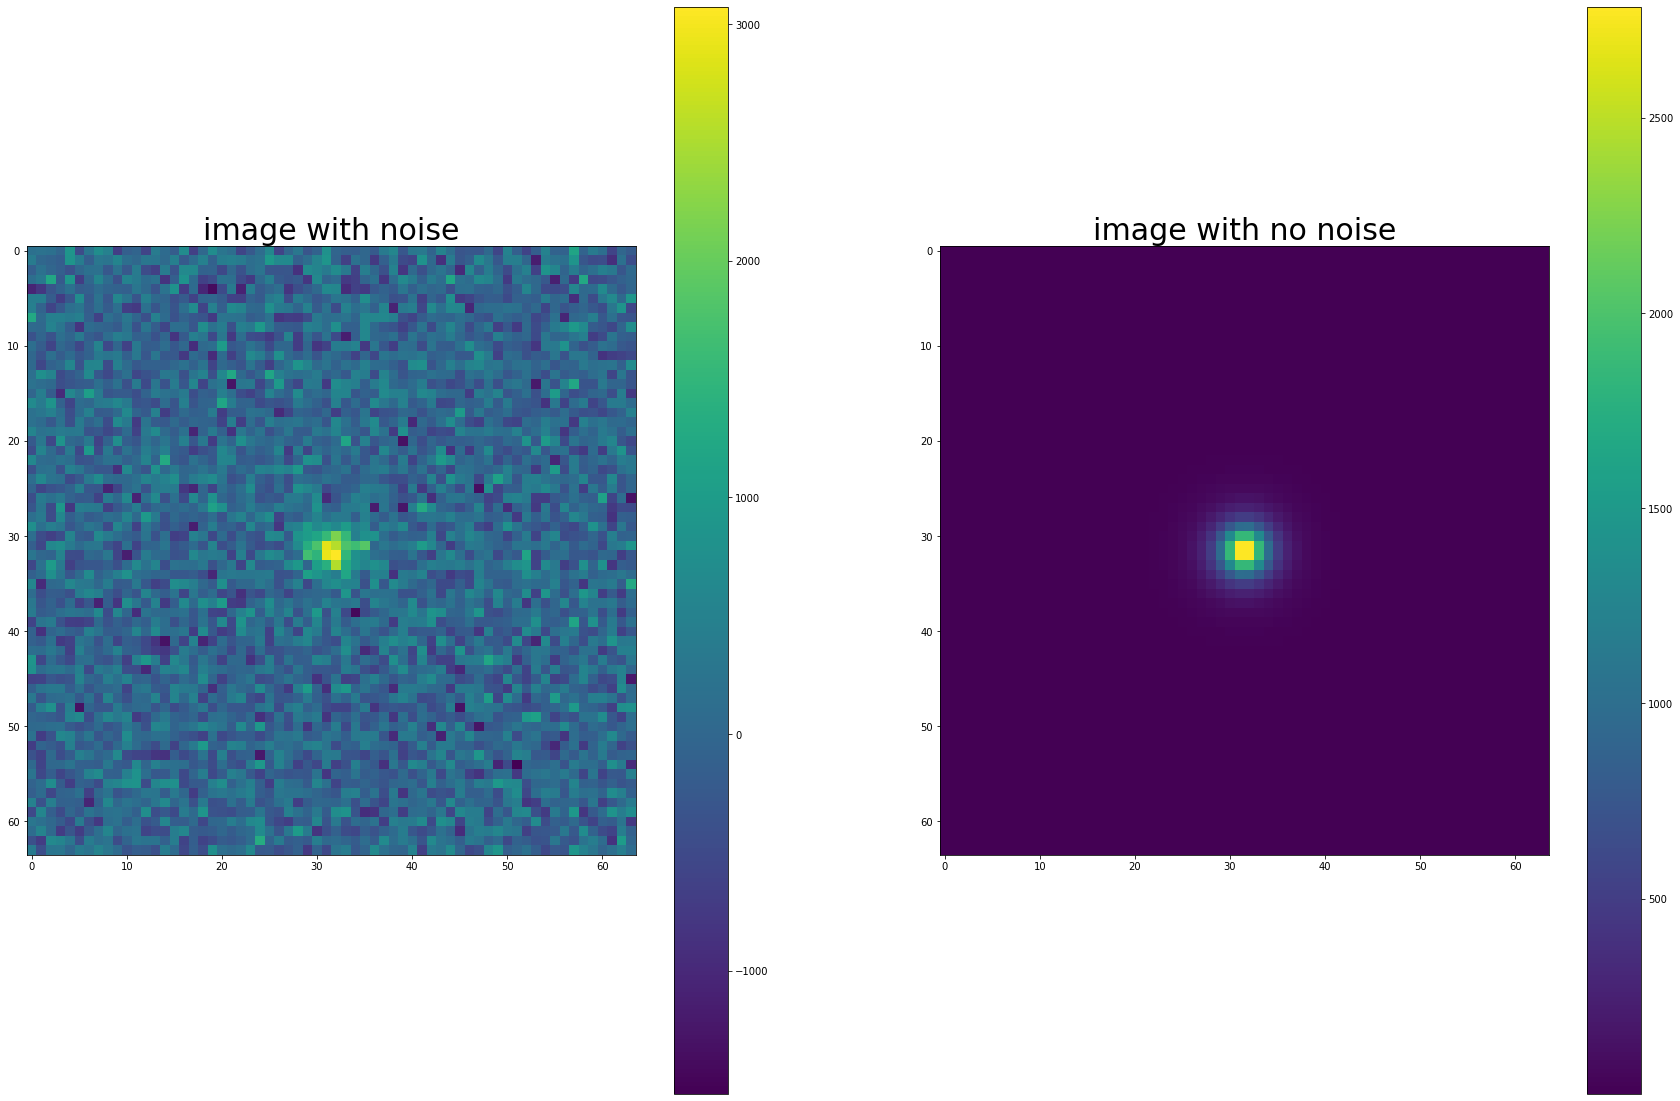

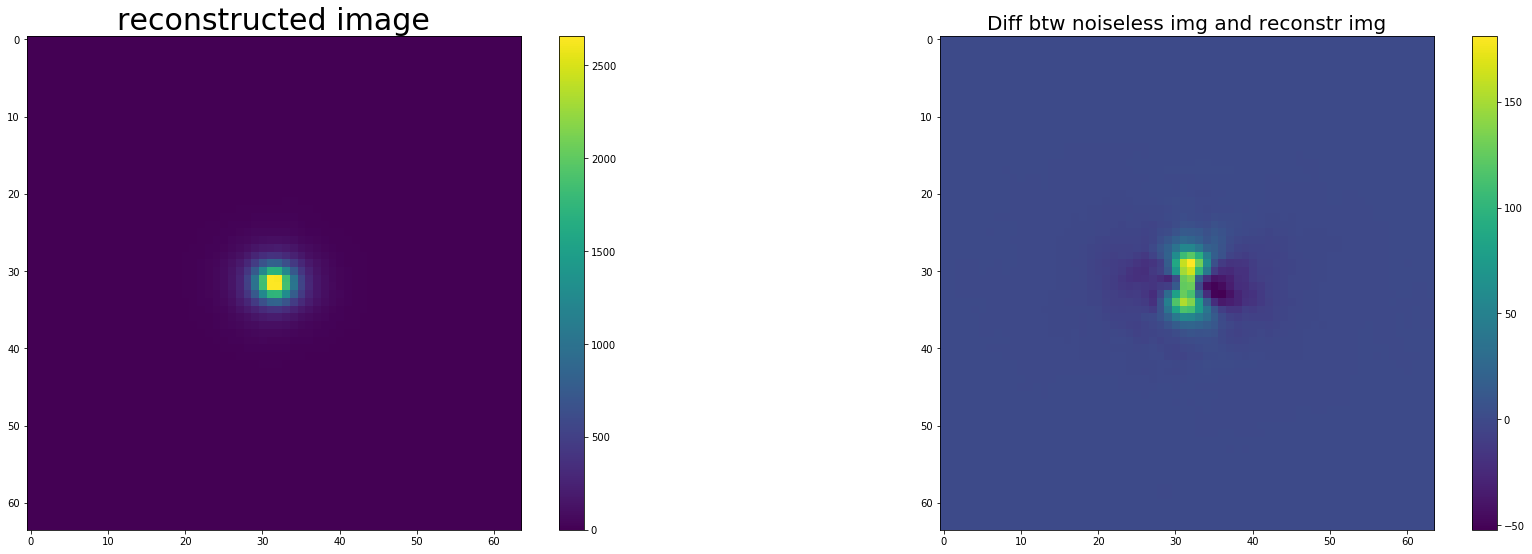

In [22]:
i=30
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no noise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

S/N= 30.204922
Sigma= 866.04596


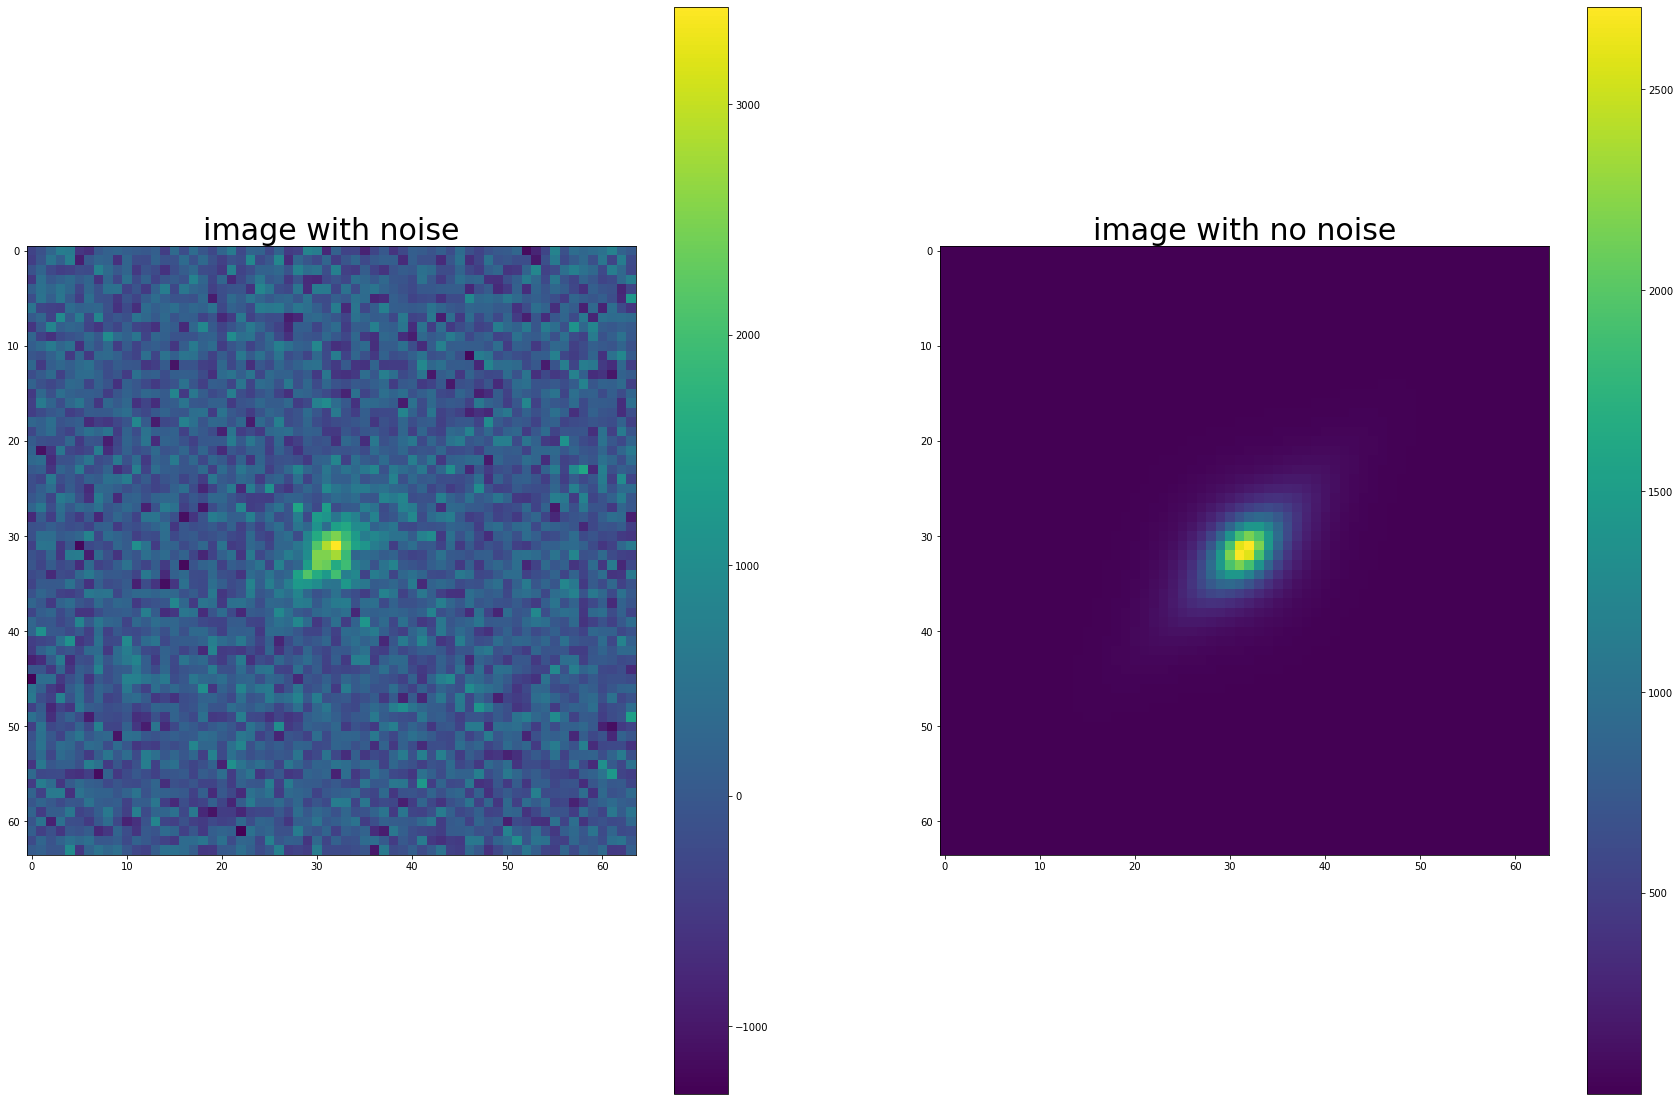

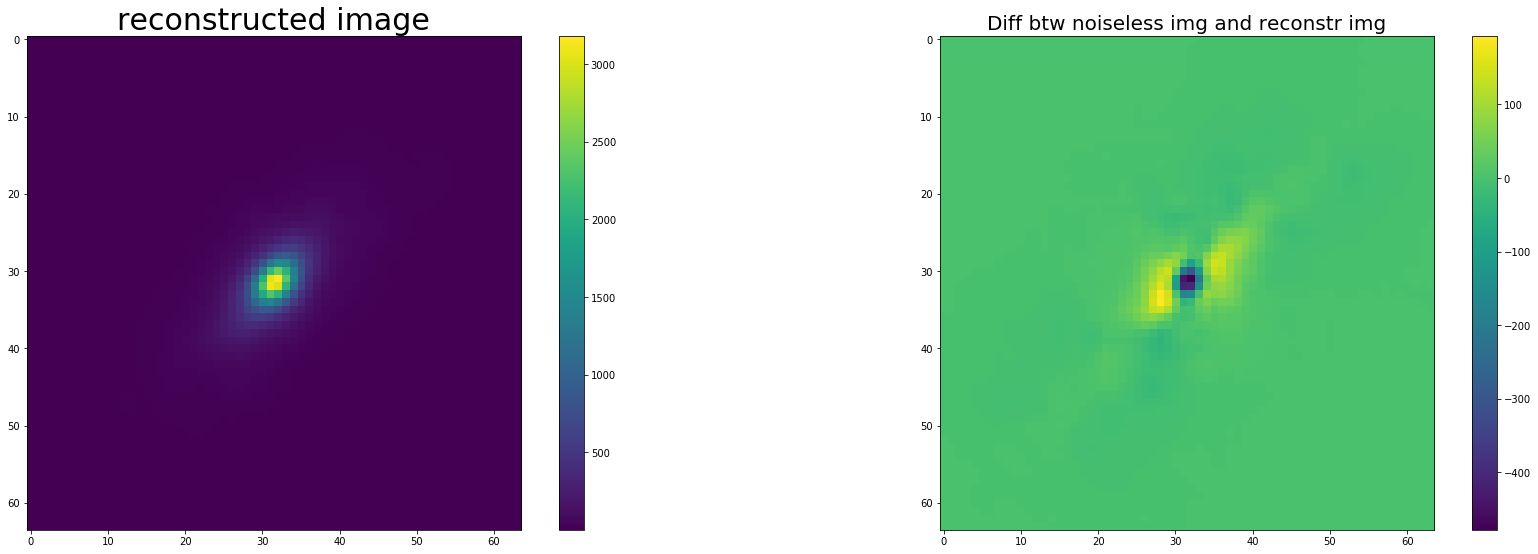

In [23]:
i=50
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no noise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

S/N= 48.08454
Sigma= 642.0952


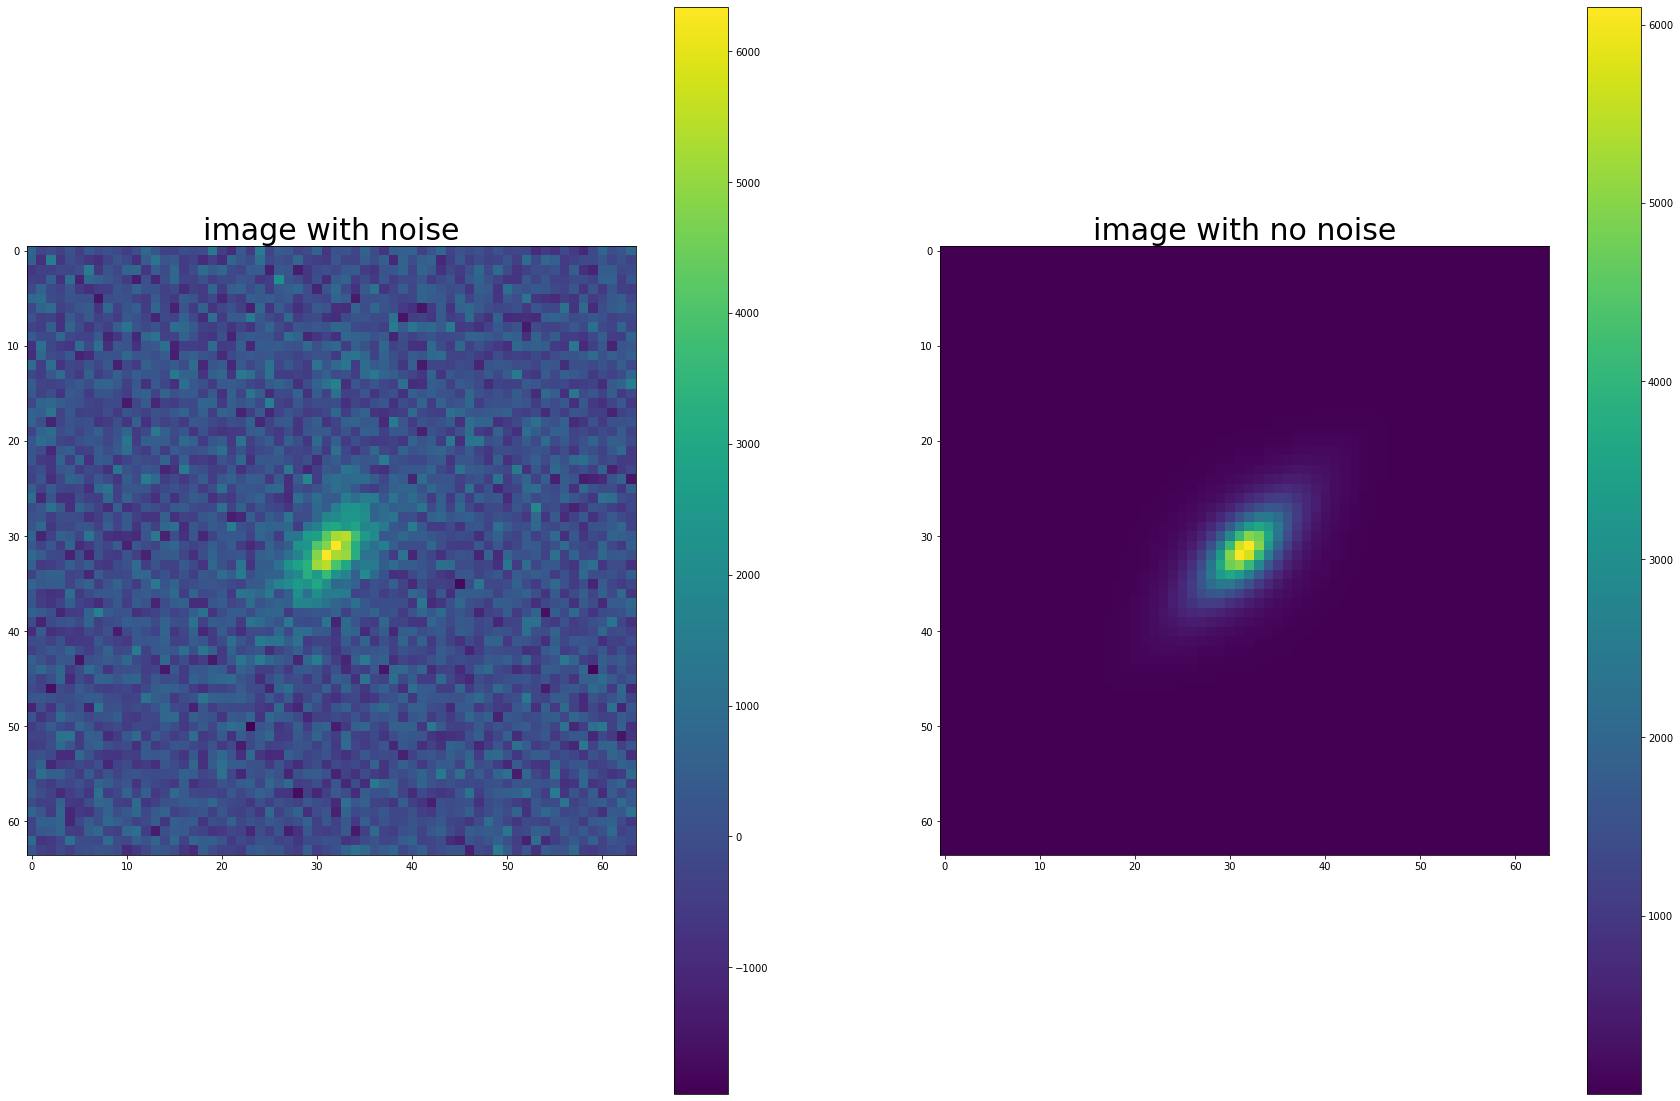

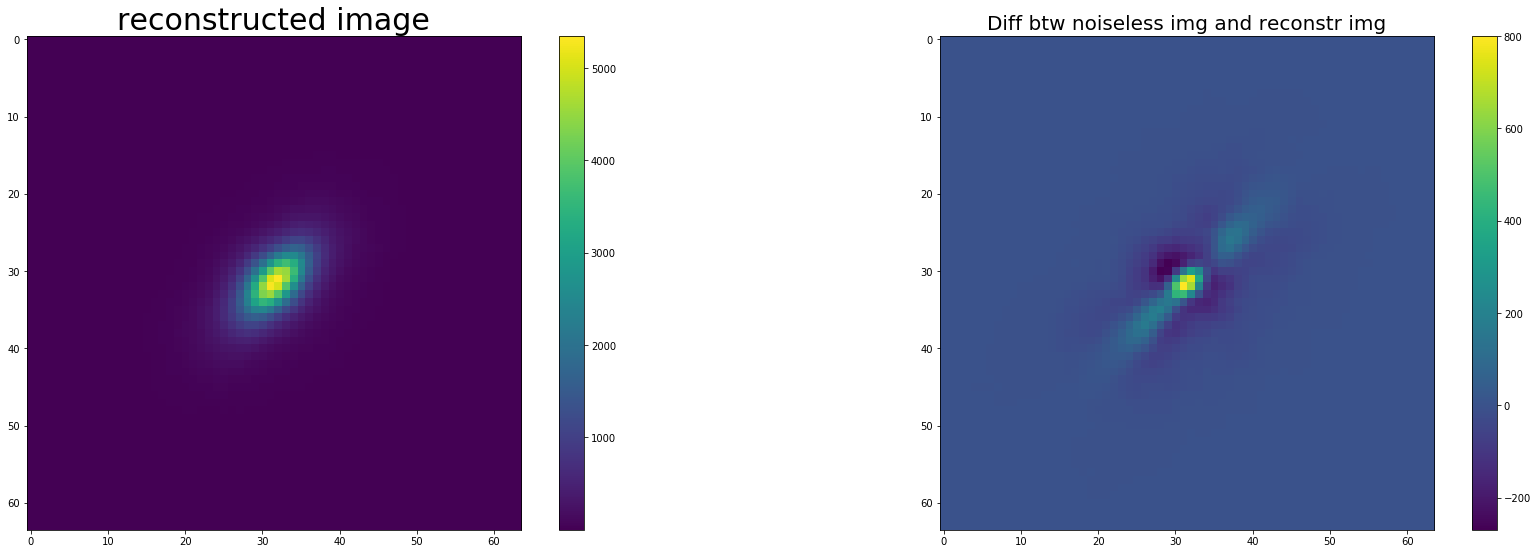

In [24]:
i=99
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no noise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

S/N= 55.329487
Sigma= 521.4189


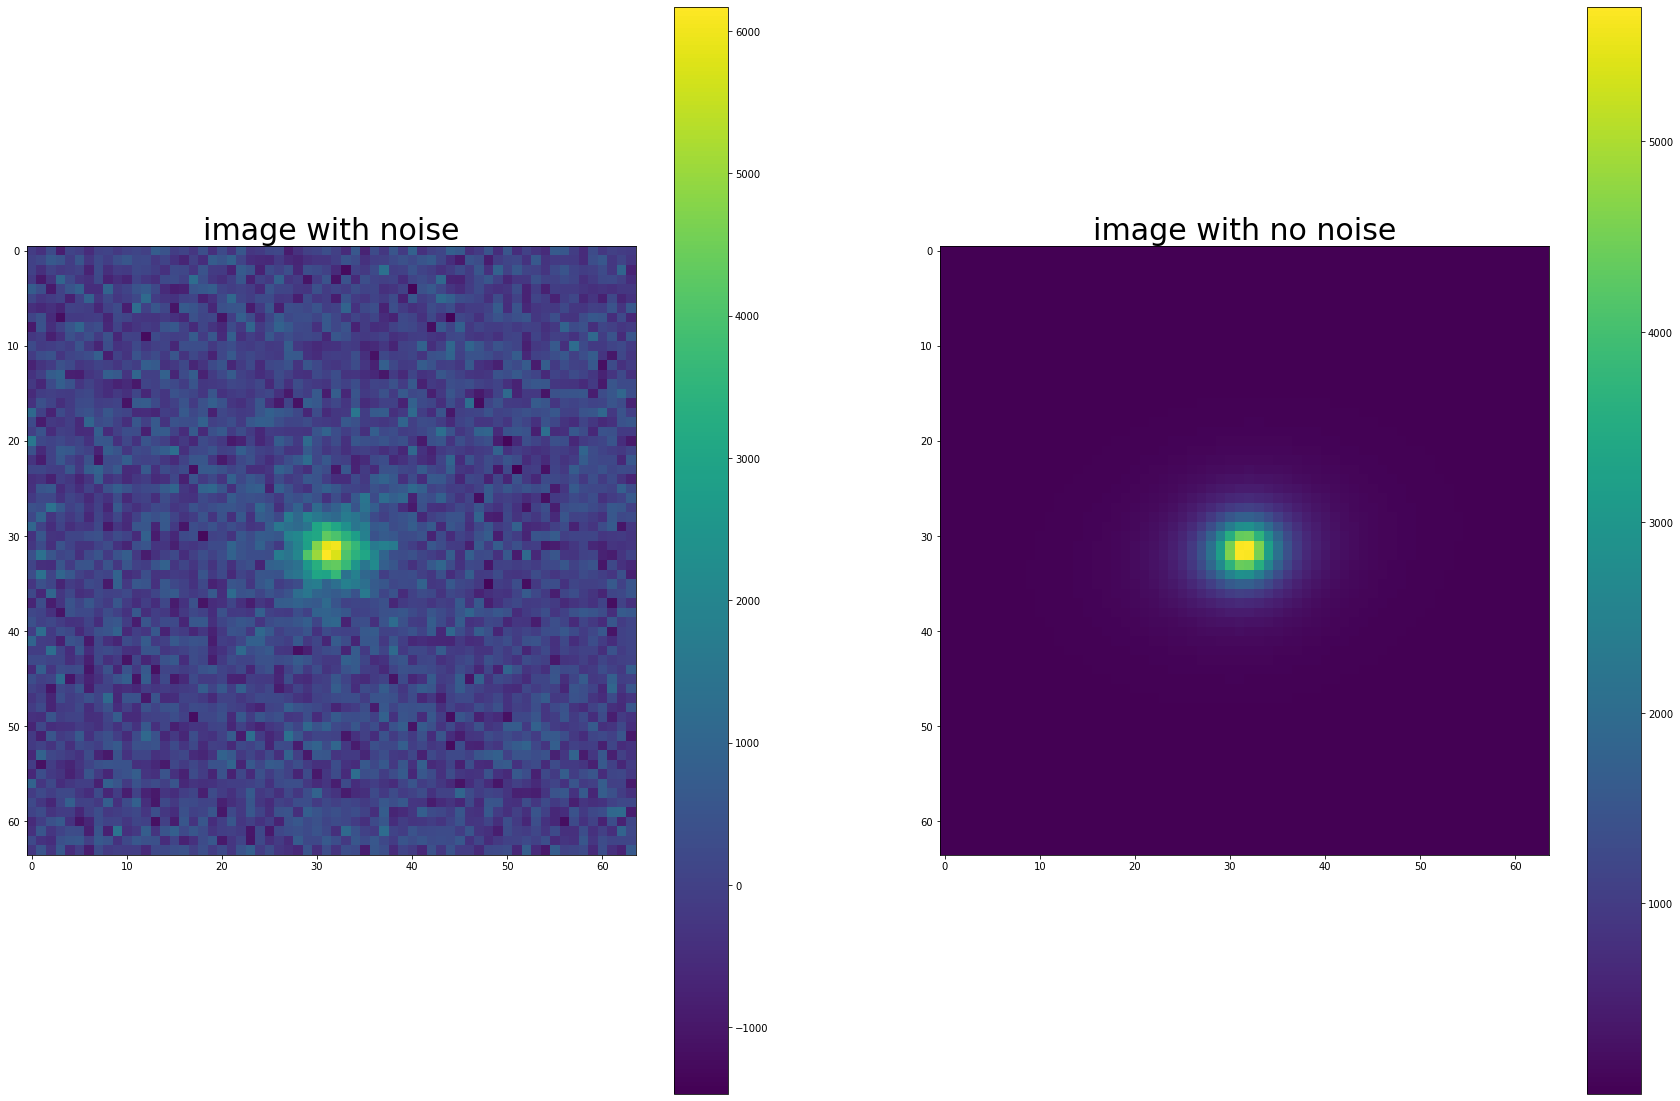

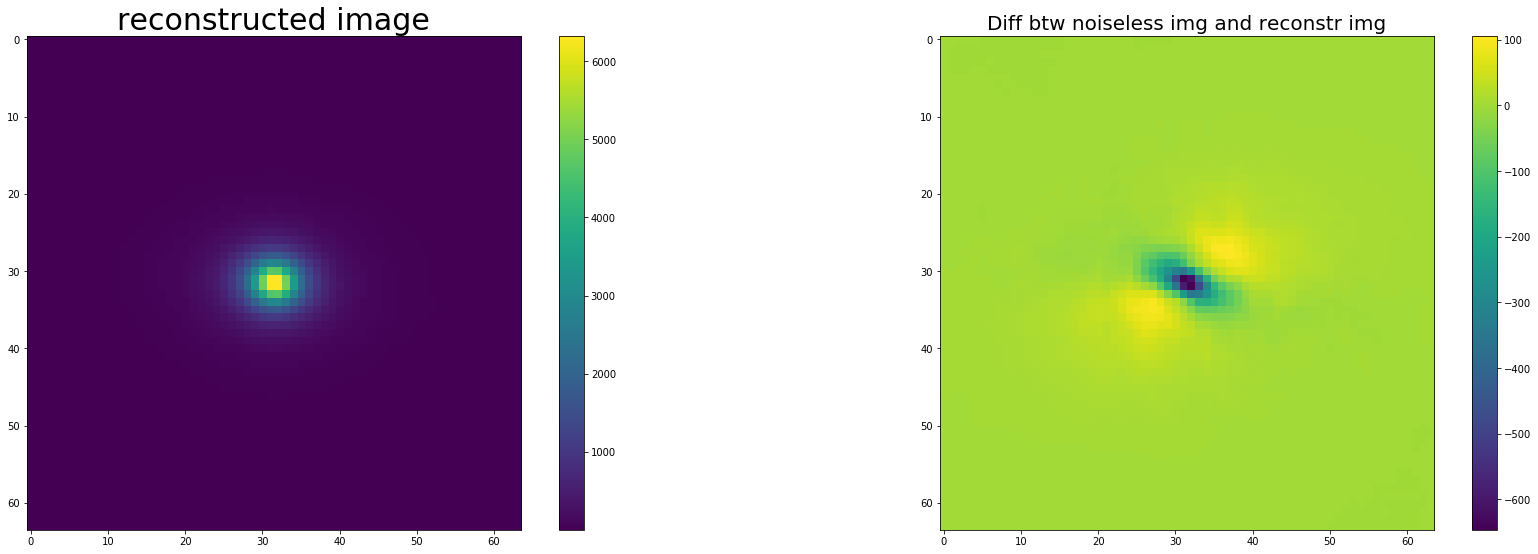

In [25]:
i=120
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no noise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

In [26]:
250/8000

0.03125

S/N= 98.72608
Sigma= 393.3481


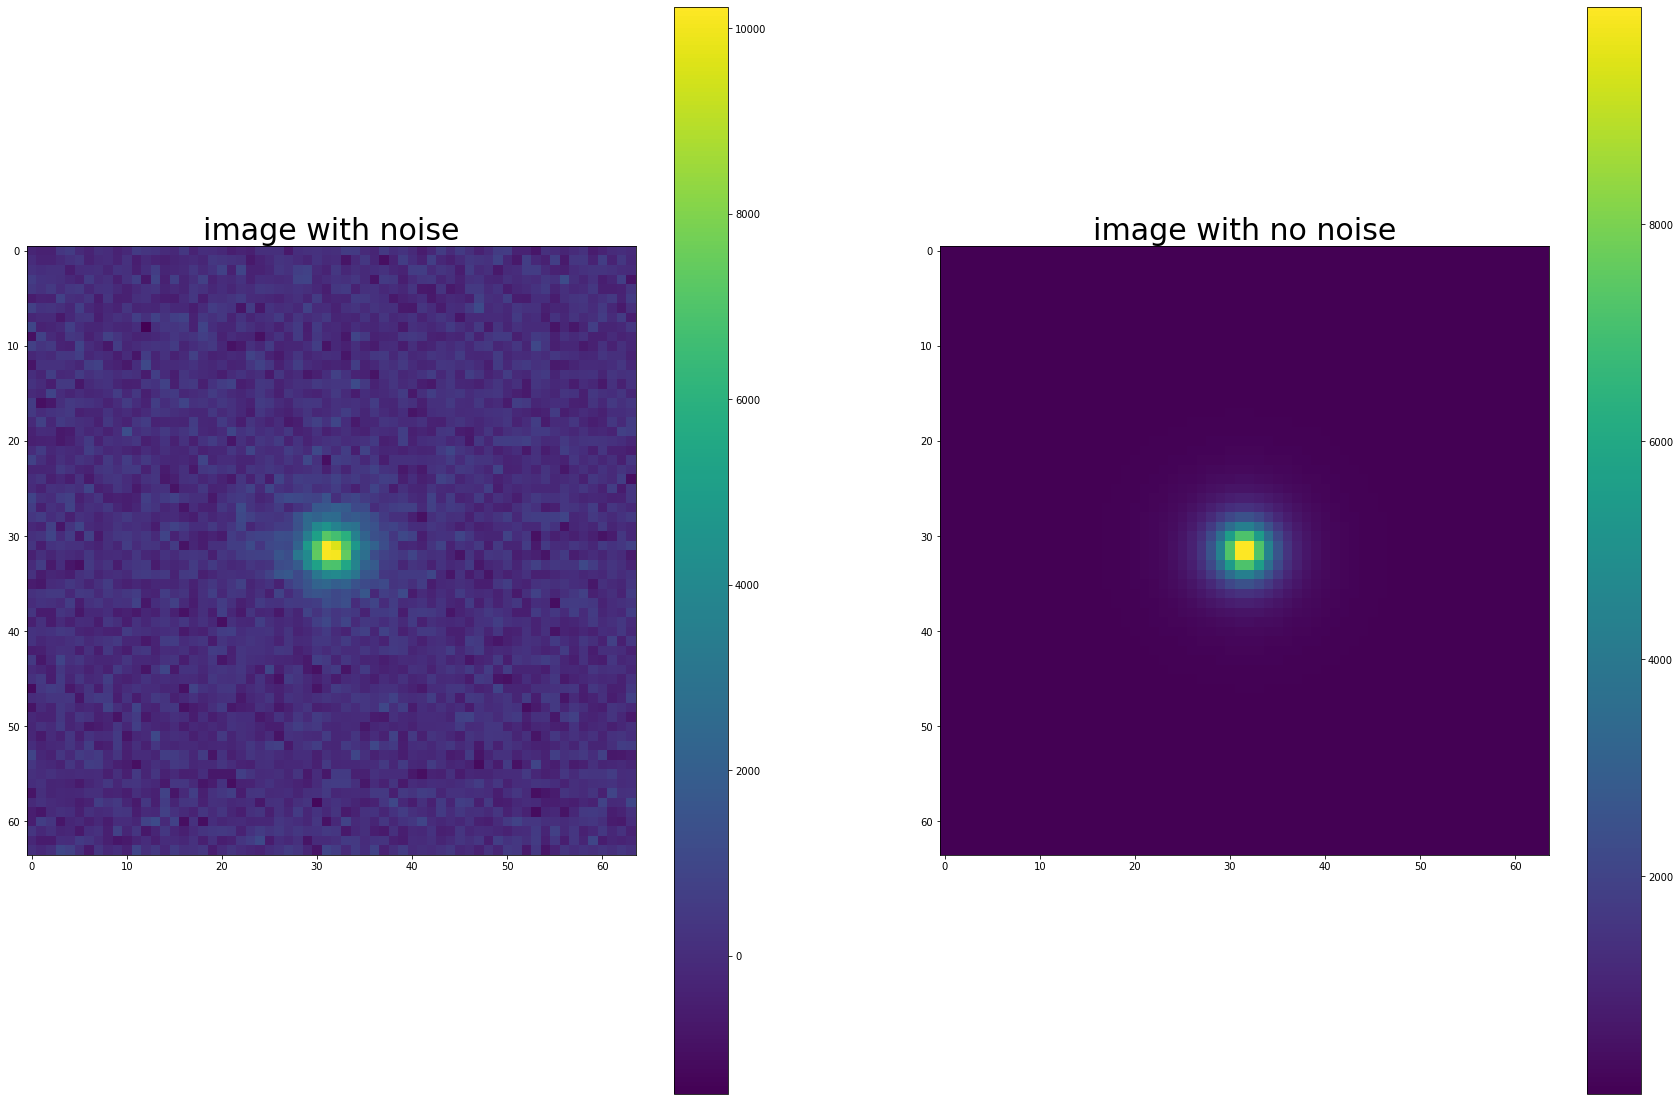

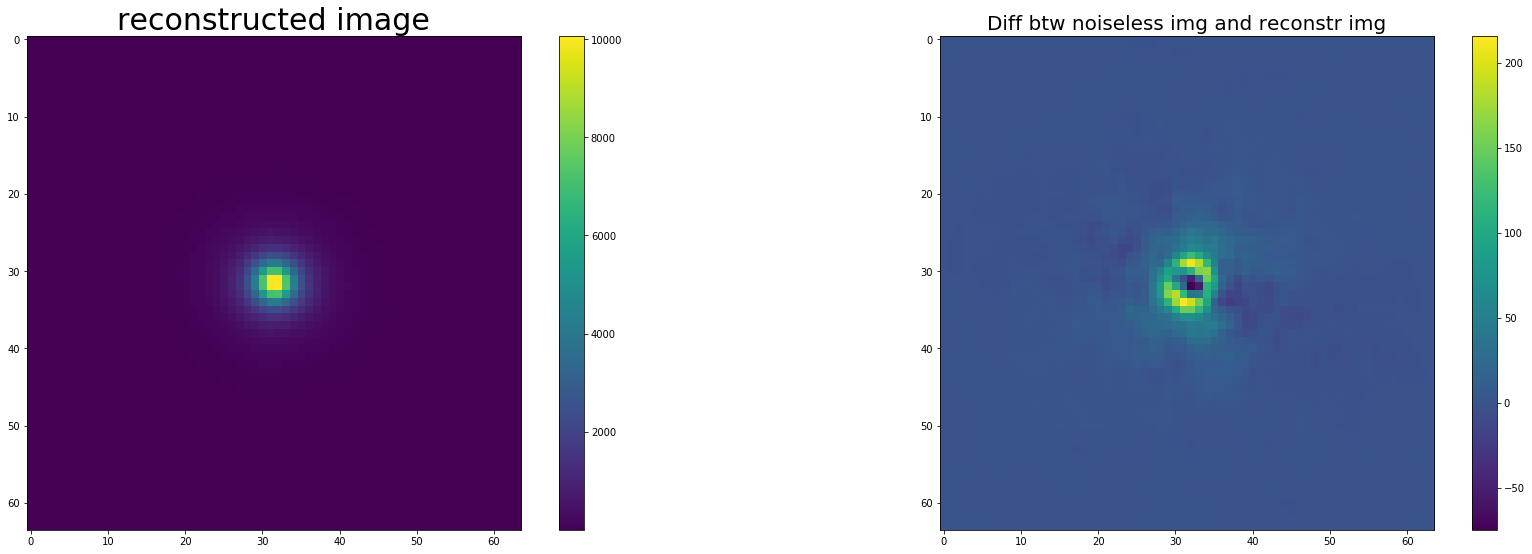

In [69]:
i=199
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no noise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

In [47]:
def p(a,b,c,d):
    fig, ax = plt.subplots(4,2, figsize=(15,10))

    # Plot original image with noise
    im = ax[0][0].imshow(a)
    fig.colorbar(im, ax=ax[0][0])
    ax[0][0].set_title('aaaaa')

    # Plot original image with no noise
    im = ax[0][1].imshow(b)
    fig.colorbar(im, ax=ax[0][1])
    ax[0][1].set_title('bbbb')    
    
    # Plot reconstructed image
    im = ax[1][0].imshow(c)
    fig.colorbar(im, ax=ax[1][0])
    ax[1][0].set_title('cccc')

    # Plot difference between original and reconstructed image

    im = ax[1][1].imshow(d)
    fig.colorbar(im, ax=ax[1][1])
    ax[1][1].set_title('dddd')
    
    
    
    
    im = ax[2][0].imshow(d)
    fig.colorbar(im, ax=ax[2][0])
    ax[1][1].set_title('dddd')


    im = ax[2][1].imshow(d)
    fig.colorbar(im, ax=ax[2][1])
    ax[1][1].set_title('dddd')    
    
    
    im = ax[3][0].imshow(d)
    fig.colorbar(im, ax=ax[3][0])
    ax[1][1].set_title('dddd')


    im = ax[3][1].imshow(d)
    fig.colorbar(im, ax=ax[3][1])
    ax[1][1].set_title('dddd')    
    
    
    
    
    
    fig.tight_layout();


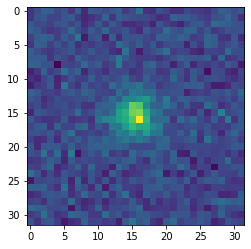

In [48]:
    fig, ax = plt.subplots(4,2, figsize=(15,10))

    # Plot original image with noise
    im = ax[0][0].imshow(a)
    fig.colorbar(im, ax=ax[0][0])
    ax[0][0].set_title('aaaaa')

    # Plot original image with no noise
    im = ax[0][1].imshow(b)
    fig.colorbar(im, ax=ax[0][1])
    ax[0][1].set_title('bbbb')    
    
    # Plot reconstructed image
    im = ax[1][0].imshow(c)
    fig.colorbar(im, ax=ax[1][0])
    ax[1][0].set_title('cccc')

    # Plot difference between original and reconstructed image

    im = ax[1][1].imshow(d)
    fig.colorbar(im, ax=ax[1][1])
    ax[1][1].set_title('dddd')
    
    
    
    
    im = ax[2][0].imshow(d)
    fig.colorbar(im, ax=ax[1][1])
    ax[1][1].set_title('dddd')


    im = ax[2][1].imshow(d)
    fig.colorbar(im, ax=ax[1][1])
    ax[1][1].set_title('dddd')    
    
    
    im = ax[3][0].imshow(d)
    fig.colorbar(im, ax=ax[1][1])
    ax[1][1].set_title('dddd')


    im = ax[3][1].imshow(d)
    fig.colorbar(im, ax=ax[1][1])
    ax[1][1].set_title('dddd')    
    

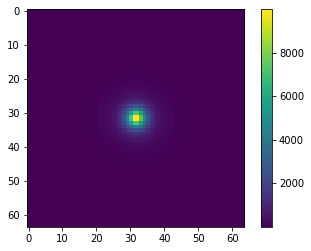

In [72]:
plt.imshow(withoutnoise[i][0])
plt.colorbar()

In [98]:
withnoise.min()

-3588.1096

In [99]:
withnoise.max()

18130.445

In [100]:
withoutnoise.min()

0.01835289

In [101]:
withoutnoise.max()

16821.453

In [106]:
reconstructed.max()

15407.799

In [107]:
reconstructed.min()

-0.19099277

In [108]:
(reconstructed-withoutnoise).max()

1468.987

In [109]:
(reconstructed-withoutnoise).min()

-1635.4482

In [161]:

def lala(m,n,imgg,title):
    im = ax[m][n].imshow(imgg, vmin=0, vmax=5000)
    ax[m][n].set_title(title)
    ax[m][n].axis('off')

def lala7(m,n,imgg,title):
    im = ax[m][n].imshow(imgg, vmin=0, vmax=5000)
    fig.colorbar(im, ax=ax[m][n])
    ax[m][n].set_title(title)
    ax[m][n].axis('off')

    
def nlala(m,n,imgg,title):
    im = ax[m][n].imshow(imgg, vmin=-1000, vmax=5000)
    ax[m][n].set_title(title)
    ax[m][n].axis('off')

def nlala7(m,n,imgg,title):
    im = ax[m][n].imshow(imgg, vmin=-1000, vmax=5000)
    fig.colorbar(im, ax=ax[m][n])
    ax[m][n].set_title(title)  
    ax[m][n].axis('off')
    
def dlala(m,n,imgg,title):
    im = ax[m][n].imshow(imgg, vmin=-500, vmax=500)
    ax[m][n].set_title(title)    
    ax[m][n].axis('off')
def dlala7(m,n,imgg,title):
    im = ax[m][n].imshow(imgg, vmin=-500, vmax=500)
    fig.colorbar(im, ax=ax[m][n])
    ax[m][n].set_title(title)  
    ax[m][n].axis('off')


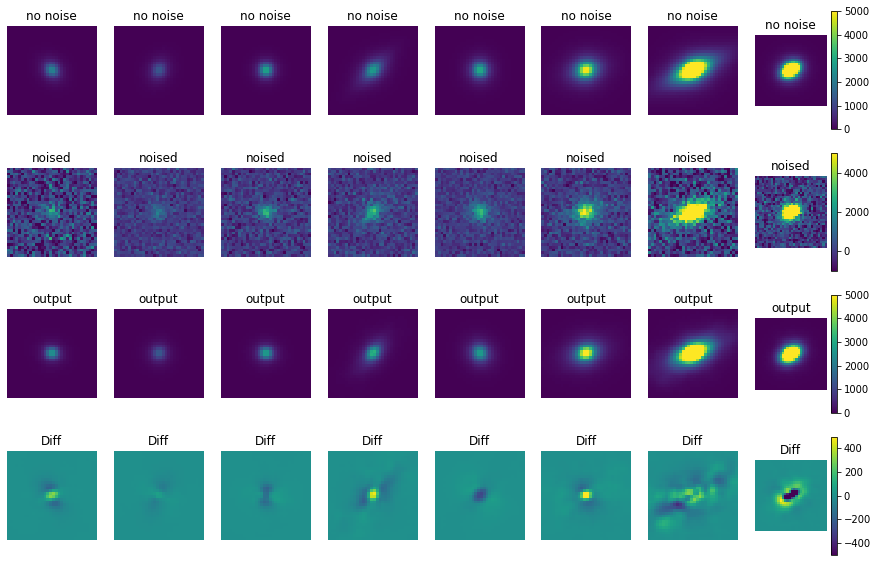

In [162]:
fig, ax = plt.subplots(4,8, figsize=(15,10))
lala(0,0,withoutnoise[0][0,16:48,16:48],'no noise')
lala(0,1,withoutnoise[10][0,16:48,16:48],'no noise')
lala(0,2,withoutnoise[30][0,16:48,16:48],'no noise')
lala(0,3,withoutnoise[50][0,16:48,16:48],'no noise')
lala(0,4,withoutnoise[70][0,16:48,16:48],'no noise')
lala(0,5,withoutnoise[90][0,16:48,16:48],'no noise')
lala(0,5,withoutnoise[110][0,16:48,16:48],'no noise')
lala(0,6,withoutnoise[160][0,16:48,16:48],'no noise')
lala7(0,7,withoutnoise[190][0,16:48,16:48],'no noise')

nlala(1,0,withnoise[0,16:48,16:48],'noised')
nlala(1,1,withnoise[10,16:48,16:48],'noised')
nlala(1,2,withnoise[30,16:48,16:48],'noised')
nlala(1,3,withnoise[50,16:48,16:48],'noised')
nlala(1,4,withnoise[70,16:48,16:48],'noised')
nlala(1,5,withnoise[90,16:48,16:48],'noised')
nlala(1,5,withnoise[110,16:48,16:48],'noised')
nlala(1,6,withnoise[160,16:48,16:48],'noised')
nlala7(1,7,withnoise[190,16:48,16:48],'noised')
#fig.colorbar( ax=ax[1][7])


lala(2,0,reconstructed[0][0,16:48,16:48],'output')
lala(2,1,reconstructed[10][0,16:48,16:48],'output')
lala(2,2,reconstructed[30][0,16:48,16:48],'output')
lala(2,3,reconstructed[50][0,16:48,16:48],'output')
lala(2,4,reconstructed[70][0,16:48,16:48],'output')
lala(2,5,reconstructed[90][0,16:48,16:48],'output')
lala(2,5,reconstructed[110][0,16:48,16:48],'output')
lala(2,6,reconstructed[160][0,16:48,16:48],'output')
lala7(2,7,reconstructed[190][0,16:48,16:48],'output')
#fig.colorbar( ax=ax[2][7])

dlala(3,0,reconstructed[0][0,16:48,16:48]-withoutnoise[0][0,16:48,16:48],'Diff')
dlala(3,1,reconstructed[10][0,16:48,16:48]-withoutnoise[10][0,16:48,16:48],'Diff')
dlala(3,2,reconstructed[30][0,16:48,16:48]-withoutnoise[30][0,16:48,16:48],'Diff')
dlala(3,3,reconstructed[50][0,16:48,16:48]-withoutnoise[50][0,16:48,16:48],'Diff')
dlala(3,4,reconstructed[70][0,16:48,16:48]-withoutnoise[70][0,16:48,16:48],'Diff')
dlala(3,5,reconstructed[90][0,16:48,16:48]-withoutnoise[90][0,16:48,16:48],'Diff')
dlala(3,5,reconstructed[110][0,16:48,16:48]-withoutnoise[110][0,16:48,16:48],'Diff')
dlala(3,6,reconstructed[160][0,16:48,16:48]-withoutnoise[160][0,16:48,16:48],'Diff')
dlala7(3,7,reconstructed[190][0,16:48,16:48]-withoutnoise[190][0,16:48,16:48],'Diff')
#fig.colorbar(ax=ax[3][7])


plt.savefig("lala.pdf")


In [155]:

def lala(m,n,imgg,title):
    im = ax[m][n].imshow(imgg)
    fig.colorbar(im, ax=ax[m][n])
    ax[m][n].set_title(title)
    ax[m][n].axis('off')

def lala7(m,n,imgg,title):
    im = ax[m][n].imshow(imgg)
    fig.colorbar(im, ax=ax[m][n])
    ax[m][n].set_title(title)
    ax[m][n].axis('off')

    
def nlala(m,n,imgg,title):
    im = ax[m][n].imshow(imgg)
    fig.colorbar(im, ax=ax[m][n])
    ax[m][n].set_title(title)
    ax[m][n].axis('off')

def nlala7(m,n,imgg,title):
    im = ax[m][n].imshow(imgg)
    fig.colorbar(im, ax=ax[m][n])
    ax[m][n].set_title(title)  
    ax[m][n].axis('off')
    
def dlala(m,n,imgg,title):
    im = ax[m][n].imshow(imgg)
    fig.colorbar(im, ax=ax[m][n])
    ax[m][n].set_title(title)    
    ax[m][n].axis('off')
def dlala7(m,n,imgg,title):
    im = ax[m][n].imshow(imgg)
    fig.colorbar(im, ax=ax[m][n])
    ax[m][n].set_title(title)  
    ax[m][n].axis('off')


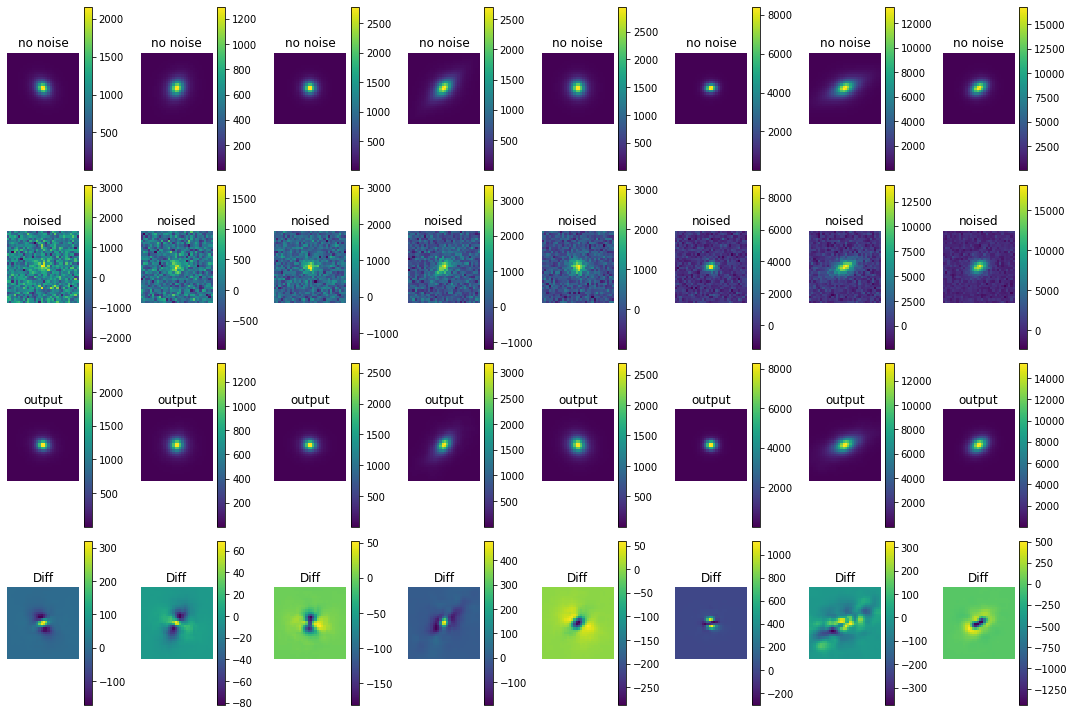

In [160]:
fig, ax = plt.subplots(4,8, figsize=(15,10))
lala(0,0,withoutnoise[0][0,16:48,16:48],'no noise')
lala(0,1,withoutnoise[10][0,16:48,16:48],'no noise')
lala(0,2,withoutnoise[30][0,16:48,16:48],'no noise')
lala(0,3,withoutnoise[50][0,16:48,16:48],'no noise')
lala(0,4,withoutnoise[70][0,16:48,16:48],'no noise')
lala(0,5,withoutnoise[90][0,16:48,16:48],'no noise')
lala(0,6,withoutnoise[160][0,16:48,16:48],'no noise')
lala7(0,7,withoutnoise[190][0,16:48,16:48],'no noise')

nlala(1,0,withnoise[0,16:48,16:48],'noised')
nlala(1,1,withnoise[10,16:48,16:48],'noised')
nlala(1,2,withnoise[30,16:48,16:48],'noised')
nlala(1,3,withnoise[50,16:48,16:48],'noised')
nlala(1,4,withnoise[70,16:48,16:48],'noised')
nlala(1,5,withnoise[90,16:48,16:48],'noised')
nlala(1,6,withnoise[160,16:48,16:48],'noised')
nlala7(1,7,withnoise[190,16:48,16:48],'noised')
#fig.colorbar( ax=ax[1][7])


lala(2,0,reconstructed[0][0,16:48,16:48],'output')
lala(2,1,reconstructed[10][0,16:48,16:48],'output')
lala(2,2,reconstructed[30][0,16:48,16:48],'output')
lala(2,3,reconstructed[50][0,16:48,16:48],'output')
lala(2,4,reconstructed[70][0,16:48,16:48],'output')
lala(2,5,reconstructed[90][0,16:48,16:48],'output')
lala(2,6,reconstructed[160][0,16:48,16:48],'output')
lala7(2,7,reconstructed[190][0,16:48,16:48],'output')
#fig.colorbar( ax=ax[2][7])

dlala(3,0,reconstructed[0][0,16:48,16:48]-withoutnoise[0][0,16:48,16:48],'Diff')
dlala(3,1,reconstructed[10][0,16:48,16:48]-withoutnoise[10][0,16:48,16:48],'Diff')
dlala(3,2,reconstructed[30][0,16:48,16:48]-withoutnoise[30][0,16:48,16:48],'Diff')
dlala(3,3,reconstructed[50][0,16:48,16:48]-withoutnoise[50][0,16:48,16:48],'Diff')
dlala(3,4,reconstructed[70][0,16:48,16:48]-withoutnoise[70][0,16:48,16:48],'Diff')
dlala(3,5,reconstructed[90][0,16:48,16:48]-withoutnoise[90][0,16:48,16:48],'Diff')
dlala(3,6,reconstructed[160][0,16:48,16:48]-withoutnoise[160][0,16:48,16:48],'Diff')
dlala7(3,7,reconstructed[190][0,16:48,16:48]-withoutnoise[190][0,16:48,16:48],'Diff')
#fig.colorbar(ax=ax[3][7])

plt.tight_layout()
plt.savefig("lala.pdf")


<Figure size 432x288 with 0 Axes>

In [ ]:
reconstructed[0][0]

S/N= 10.154267
Sigma= 315.6861


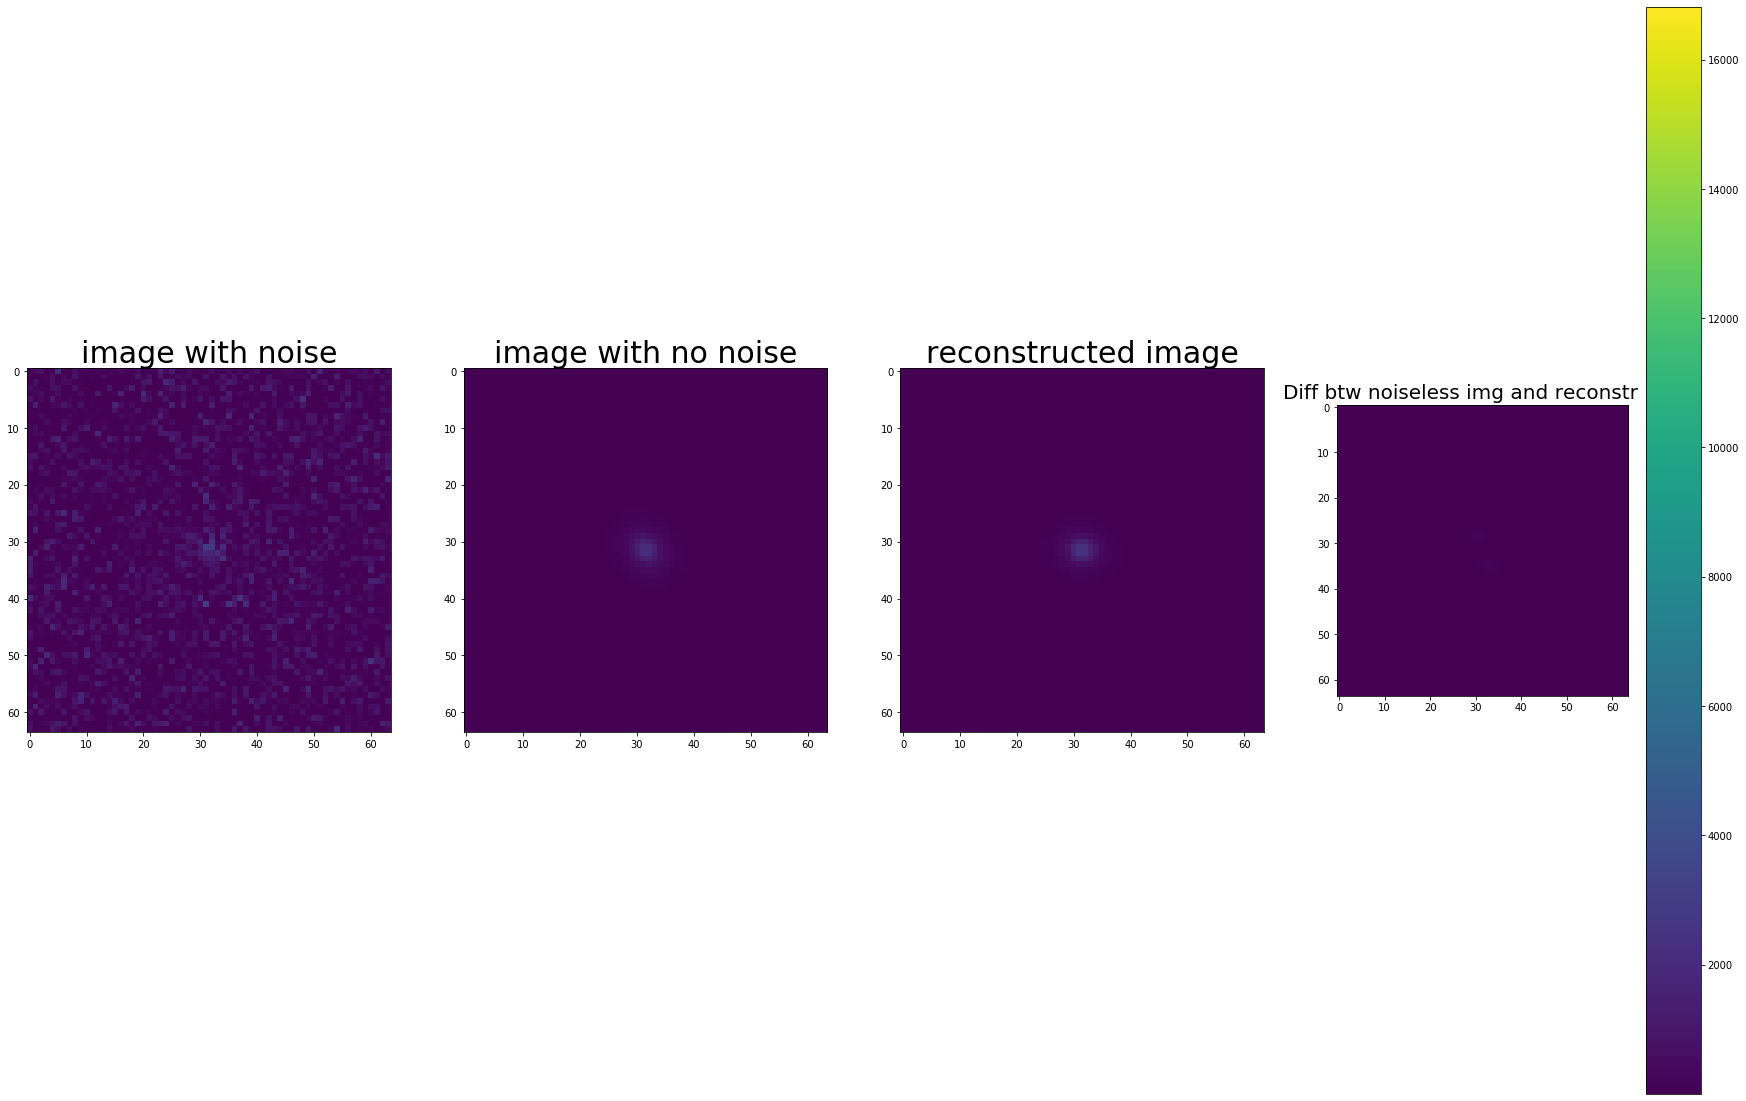

In [28]:
i=0
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=4,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 4, 1)
plt.imshow(withnoise[i])
plt.clim(withoutnoise.min(),withoutnoise.max())
plt.title("image with noise", fontsize=30)

plt.subplot(1, 4, 2)
plt.imshow(img_in)
plt.clim(withoutnoise.min(),withoutnoise.max())
plt.title("image with no noise" , fontsize=30)

plt.subplot(1, 4, 3)  
plt.imshow(img_out) 
plt.clim(withoutnoise.min(),withoutnoise.max())
plt.title("reconstructed image" , fontsize=30)


plt.subplot(1, 4, 4) 
plt.imshow(img_in-img_out) 
plt.clim(withoutnoise.min(),withoutnoise.max())
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()


In [30]:
i=230
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no xnoise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

IndexError: index 230 is out of bounds for axis 0 with size 200

In [68]:
i=280
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no xnoise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

IndexError: index 280 is out of bounds for axis 0 with size 200

In [ ]:
i=350
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no xnoise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

In [ ]:
i=400
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no xnoise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

In [ ]:
i=490
print("S/N=",snr_sorted[i])
print("Sigma=",sigma[i])
#plt.figure(figsize=(30,20))


img_in=withoutnoise[i][0]
img_out=reconstructed[i][0]

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))

plt.subplot(1, 2, 1)
plt.imshow(withnoise[i])
plt.title("image with noise", fontsize=30)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_in)
plt.title("image with no xnoise" , fontsize=30)
plt.colorbar()

plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True,figsize=(30,20))
plt.subplot(2, 2, 1)  
plt.imshow(img_out) 
plt.title("reconstructed image" , fontsize=30)
plt.colorbar()


plt.subplot(2, 2, 2) 
plt.imshow(img_in-img_out) 
plt.title("Diff btw noiseless img and reconstr img" , fontsize=20)
plt.colorbar()

In [ ]:
250/5000

In [ ]:
L1 loss 
center pixels more weights --> model capacity 
general loss --> smoothniess 